### 캐글즐기기 파트4 * Bayesian Statistics: Techniques and Models

### link : https://www.coursera.org/learn/mcmc-bayesian-statistics
### (베이지안) Week4. Count data and hierarchical modeling - 이상열


#### 10. Poisson Regression

- Introduction to Poisson regression
- JAGS model (Poisson regression)
- Predictive distributions1
- Prior sensitivity analysis

#### 11. Hierarchical Modeling

- Correlated data
- Normal hierarchical model
- Prior predictive simulation
- JAGS model and model checking (hierarchical modeling)
- Posterior predictive simulation
- Linear regression example
- Linear regression example in JAGS

#### Mixture Models
- Mixture model in JAGS

### Introduction to Poisson regression

![title](img/week4_1.png)

- 선형 회귀 분석에 적합할 수 있지만 여기에는 몇 가지 단점이 있습니다. 우선, 카운트는 일반적으로 마이너스 값이 없습니다. 그리고 차이는 일정하지 않을 수도 있습니다. 포아송 분포는 카운트 데이터에 자연스러운 가능성을 제공합니다.

- yi는 주어진 람다 i가 포아송 분포와 독립적이며 평균 람다 i와 같습니다. 람다는 y의 분산이기도합니다. 따라서 카운트가 더 높을 것으로 예상되면 카운트의 변동성이 높아질 것으로 예상됩니다.

- 우리는 로지스틱 회귀와 같은 문제를 겪을 것입니다. 포아송 분포에서 기대 값은 0보다 커야합니다.(로그 링크 함수 사용)

- 회귀 분석에서는 응답의 평균을 직접 모델링합니다. 그래서 우리는 y의 로그에 모델을 맞추는 것, 여기서 모델링 한 것과는 다른데 y의 예상 값에 대한 로그를 작성한다.


### Lesson 10: Poisson regression

#### Data
- For an example of Poisson regression, we’ll use the badhealth data set from the COUNT package in R.

In [3]:
#install.packages("COUNT", repos='http://cran.r-project.org')
library(COUNT)

Loading required package: msme
Loading required package: MASS
Loading required package: lattice
Loading required package: sandwich


In [5]:
data("badhealth")
#?badhealth
head(badhealth)

numvisit,badh,age
30,0,58
20,0,54
16,0,44
20,0,57
15,0,33
15,0,28


In [6]:
any(is.na(badhealth))

[1] FALSE

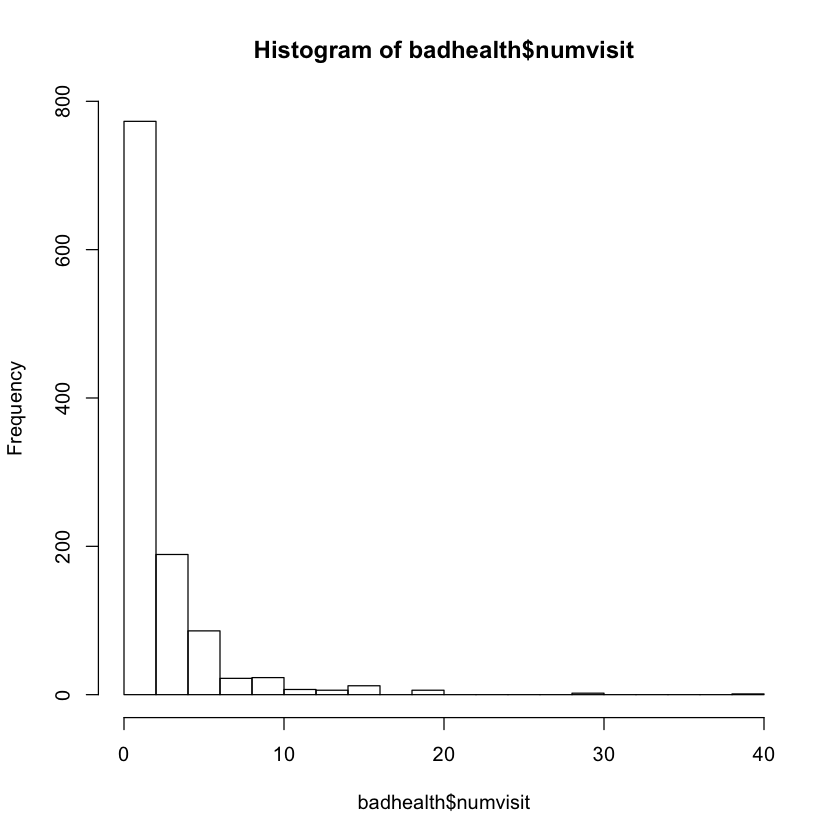

In [7]:
hist(badhealth$numvisit, breaks=20)

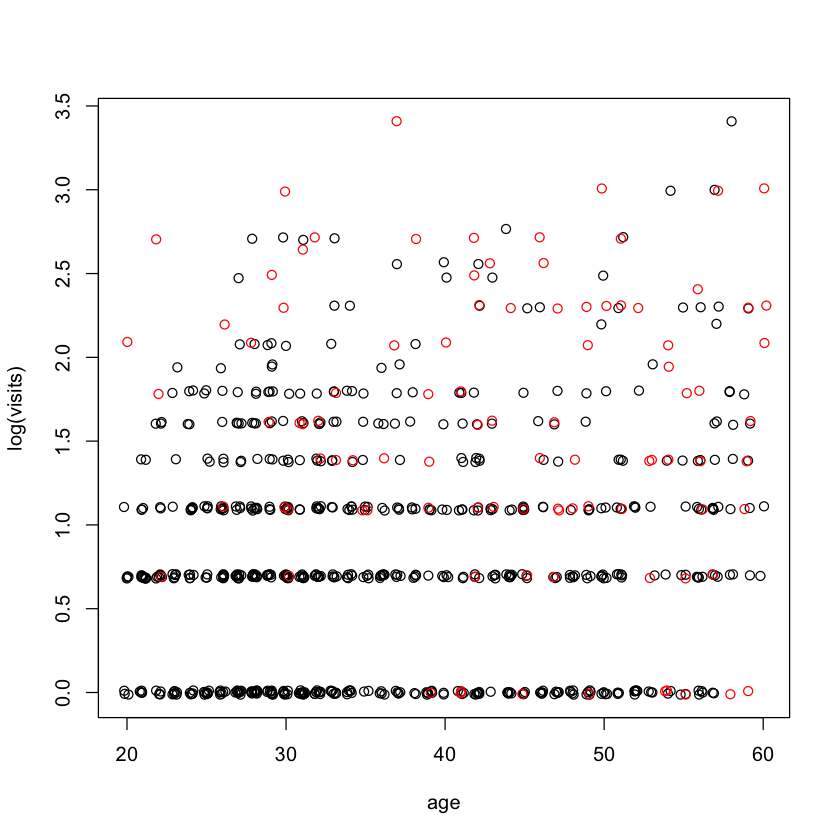

In [8]:
plot(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==0, xlab="age", ylab="log(visits)")
points(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==1, col="red")

- 빨간 점이 많지 않습니다. 그들 중 많은 사람들이 여기에 있기 때문에 건강에 좋지 않은 것처럼 보이는 것은 당연히 의사를 더 많이 방문하는 것과 관련이 있습니다.


### Models

- 나이와 건강 상태 모두 의사 방문 횟수와 관련이있는 것으로 나타났습니다. 
- 두 변수에 대한 모델 용어를 포함해야합니다. 건강한 사람과 그렇지 않은 사람간에 나이 / 방문 관계가 다르다면 우리는 상호 작용 용어도 포함시켜야합니다. 전체 모델을 여기에 맞춰서 간단한 모델과 비교해 보겠습니다.

In [9]:
library("rjags")

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


In [10]:
mod_string = " model {
    for (i in 1:length(numvisit)) {
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i] + b_intx*age[i]*badh[i]
    }
    
    int ~ dnorm(0.0, 1.0/1e6)
    b_badh ~ dnorm(0.0, 1.0/1e4)
    b_age ~ dnorm(0.0, 1.0/1e4)
    b_intx ~ dnorm(0.0, 1.0/1e4)
} "

In [11]:
set.seed(102)
data_jags = as.list(badhealth)
params = c("int", "b_badh", "b_age", "b_intx")

In [12]:
mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 4
   Total graph size: 3673

Initializing model



In [13]:
mod_sim = coda.samples(model=mod,
                        variable.names=params,
                        n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

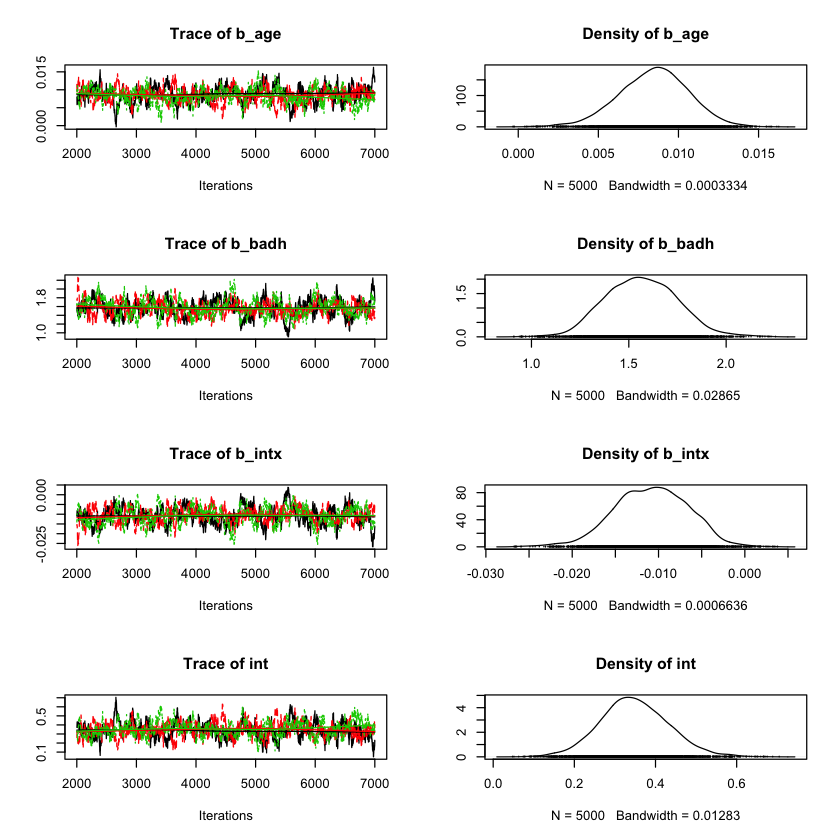

In [14]:
## convergence diagnostics
plot(mod_sim)

Potential scale reduction factors:

       Point est. Upper C.I.
b_age        1.02       1.07
b_badh       1.02       1.05
b_intx       1.02       1.04
int          1.02       1.07

Multivariate psrf

1.02

,b_age,b_badh,b_intx,int
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000
Lag 1,0.9607135,0.9666728,0.9684790,0.9589160
Lag 5,0.8522954,0.8690444,0.8757892,0.8483997
Lag 10,0.7376658,0.7636976,0.7742018,0.7332670
Lag 50,0.2448485,0.2583784,0.2697250,0.2467384


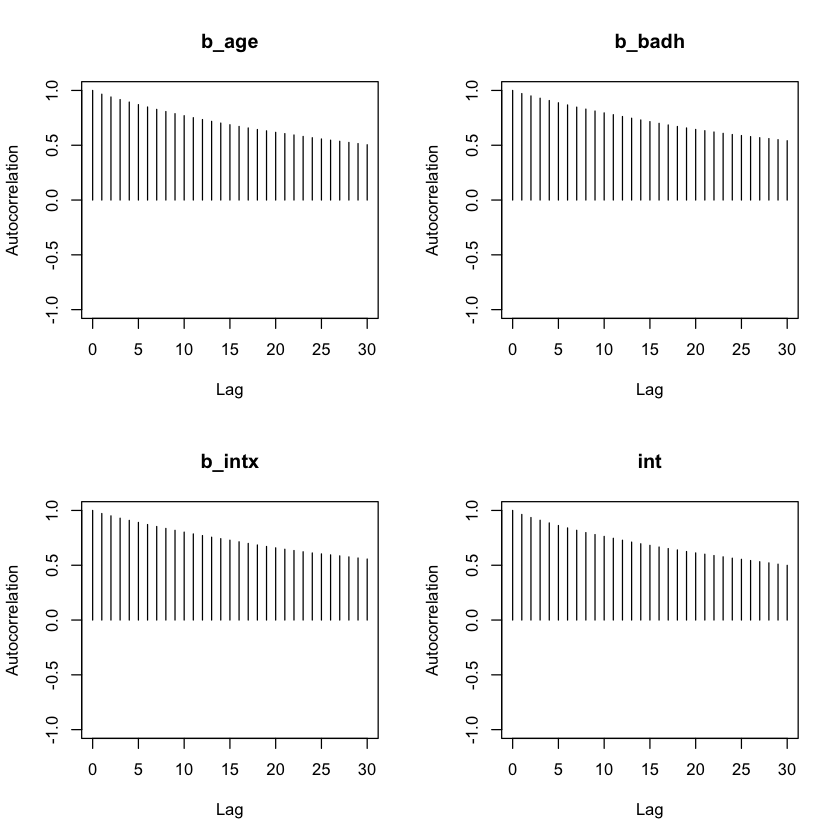

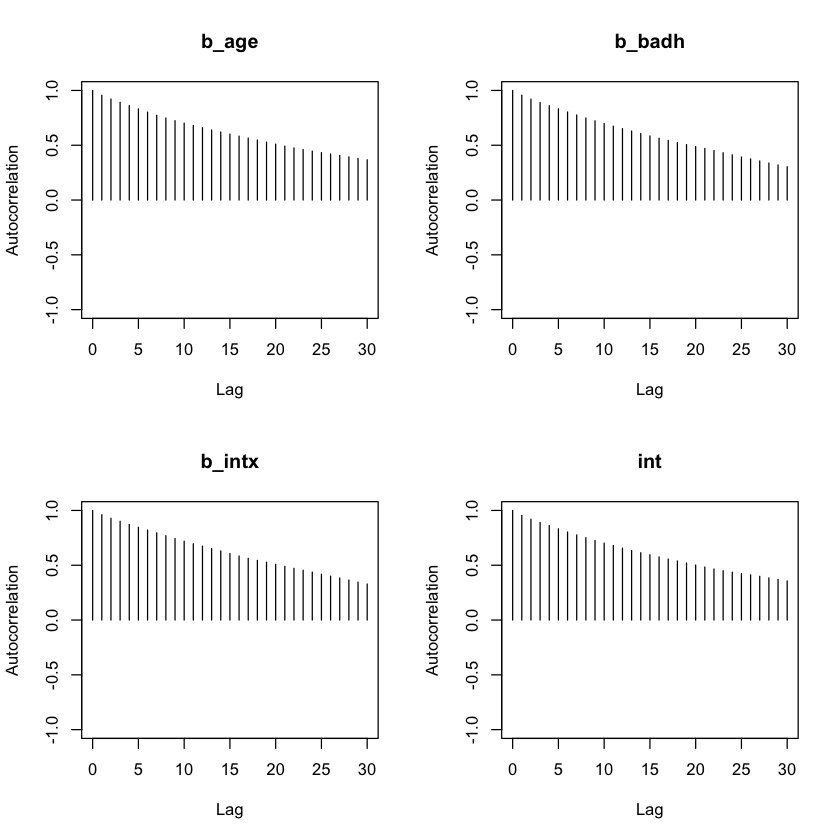

b_age   b_badh   b_intx      int 
223.5500 193.9470 192.6390 232.0187

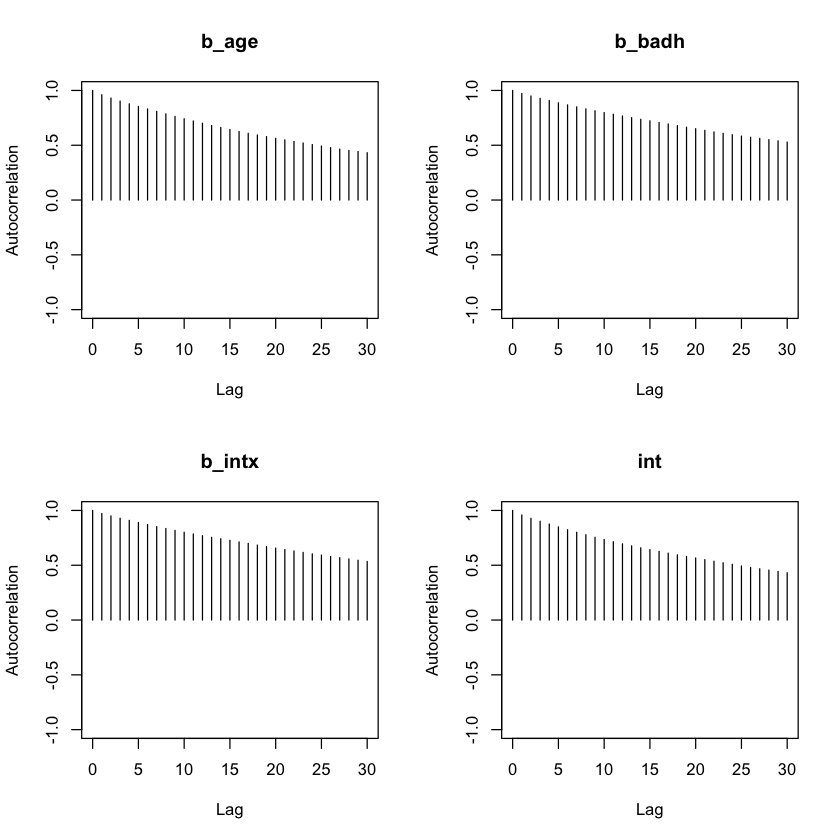

In [15]:
gelman.diag(mod_sim)
autocorr.diag(mod_sim)
autocorr.plot(mod_sim)
effectiveSize(mod_sim)

## compute DIC
dic = dic.samples(mod, n.iter=1e3)

### Model checking
- 모델의 성능에 대한 일반적인 아이디어를 얻으려면 평소와 같이 예측 된 값과 잔차를 살펴볼 수 있습니다. 
- 우리가 λ에 대한 예측을 얻으려면 링크 함수의 역함수를 적용해야한다는 것을 잊지 마십시오.

In [16]:
X = as.matrix(badhealth[,-1])
X = cbind(X, with(badhealth, badh*age))
head(X)

badh,age,
0,58,0
0,54,0
0,44,0
0,57,0
0,33,0
0,28,0


In [17]:
(pmed_coef = apply(mod_csim, 2, median))

b_age       b_badh       b_intx          int 
 0.008548613  1.562546890 -0.010759397  0.345509700

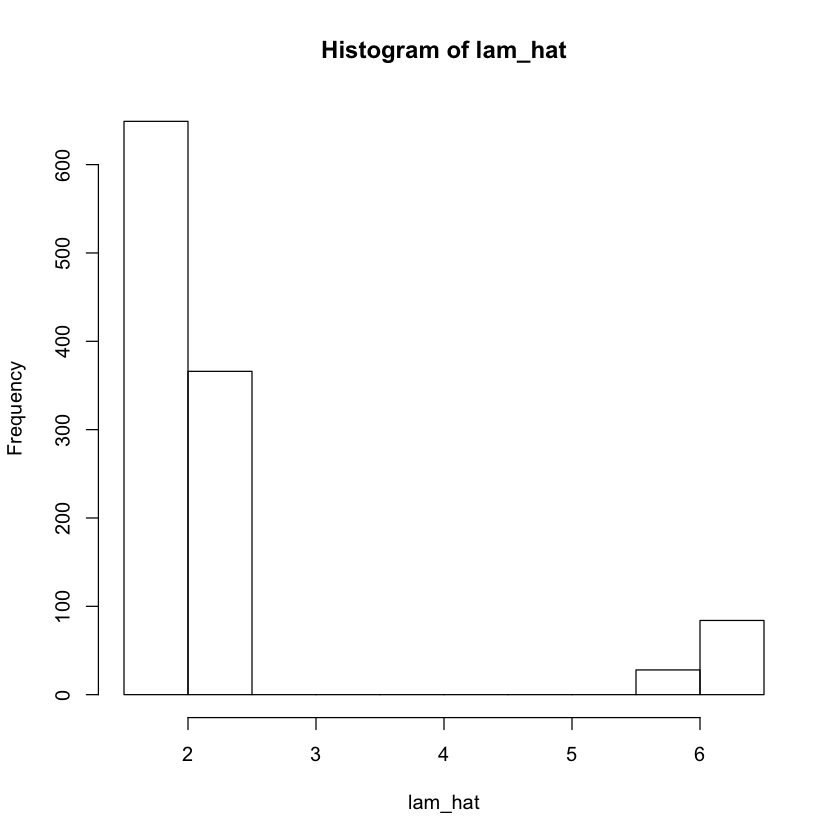

In [18]:
llam_hat = pmed_coef["int"] + X %*% pmed_coef[c("b_badh", "b_age", "b_intx")]
lam_hat = exp(llam_hat)

hist(lam_hat)

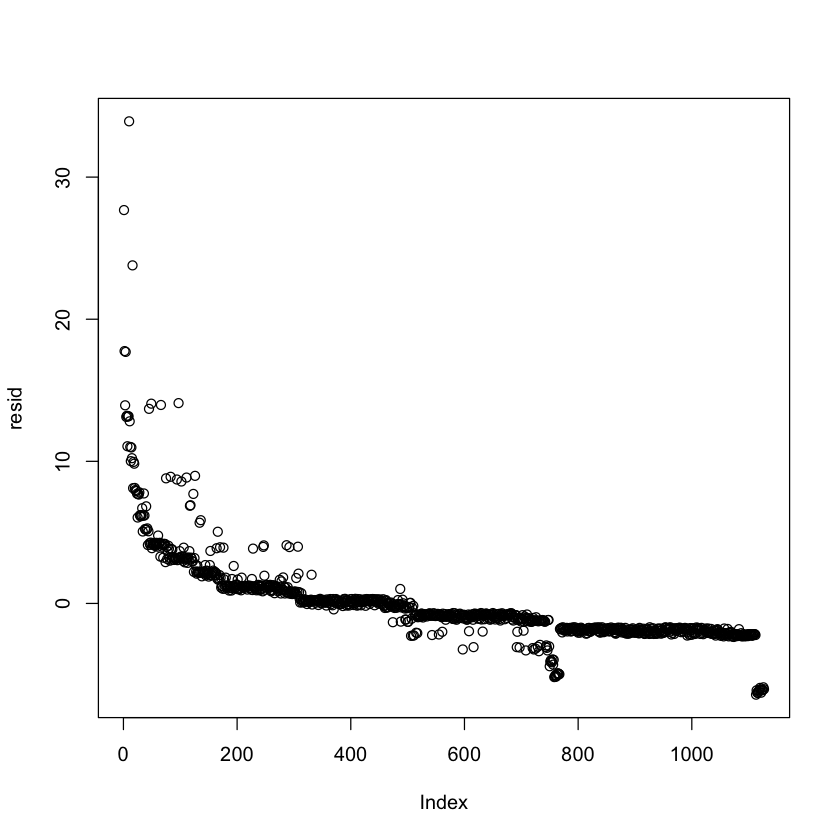

In [19]:
resid = badhealth$numvisit - lam_hat
plot(resid) # the data were ordered

-  Ordinarily we would be alarmed by this plot. The index of the data seems to have something to do, with the value of the residual which would suggest that the data are not independent. .

- 이 경우 데이터가 사전 정렬 된 것으로 나타납니다. 의사 방문 횟수에 따라 주문했습니다. 

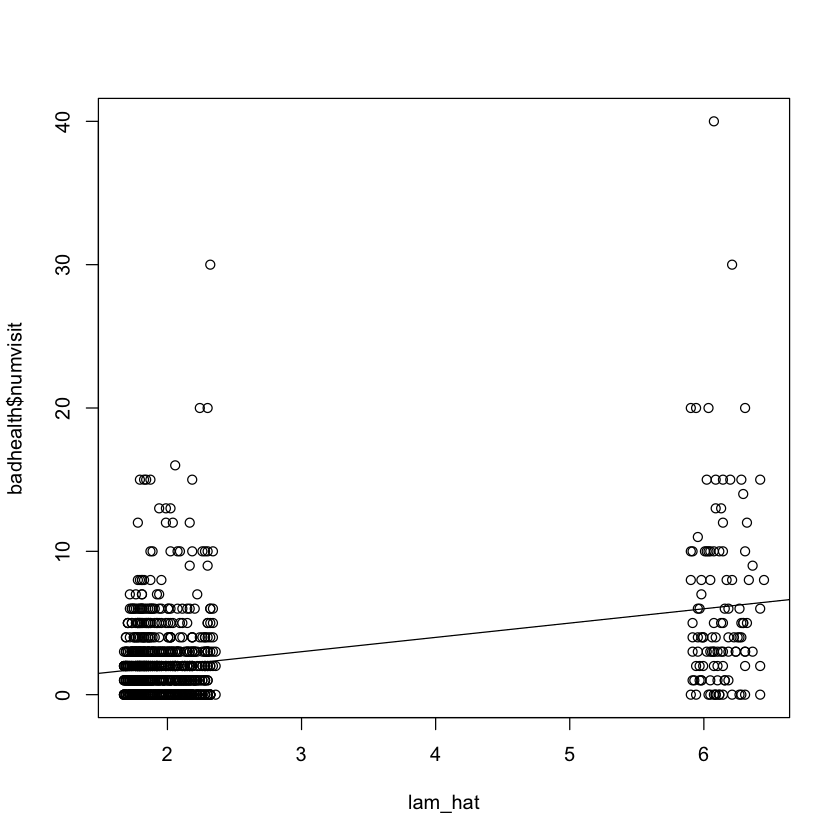

In [20]:
plot(lam_hat, badhealth$numvisit)
abline(0.0, 1.0)

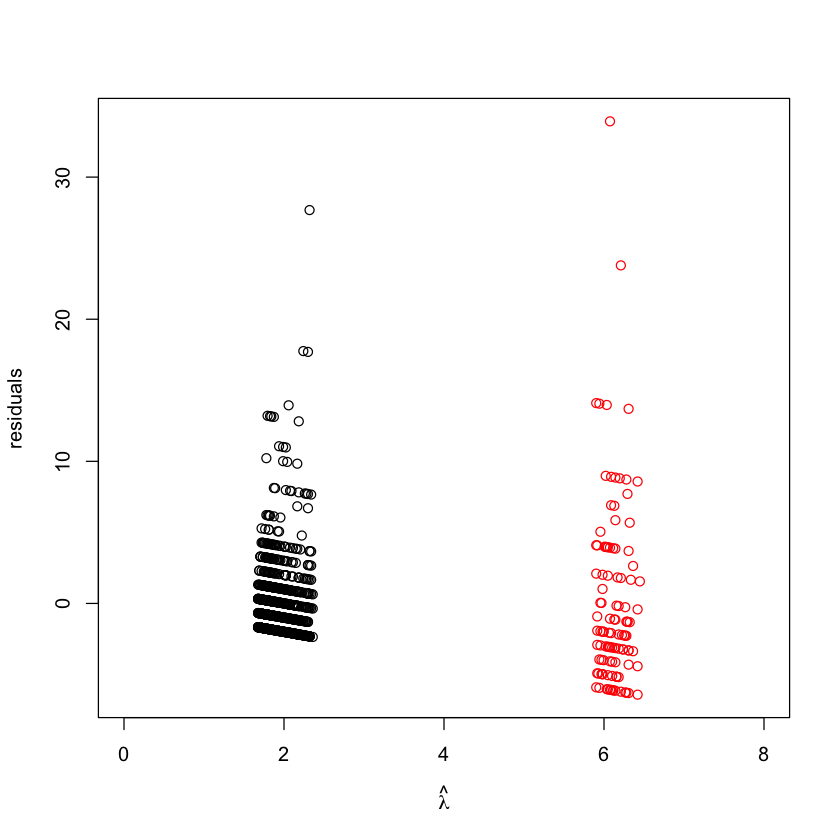

In [21]:
plot(lam_hat[which(badhealth$badh==0)], resid[which(badhealth$badh==0)], xlim=c(0, 8), ylab="residuals", xlab=expression(hat(lambda)), ylim=range(resid))
points(lam_hat[which(badhealth$badh==1)], resid[which(badhealth$badh==1)], col="red")

- Interestingly, the model separated the predicted number of visits according to whether or not the person had bad health. 

- If the person had bad health, the model predicts they'll have about six visits. And if they don't have bad health the model predicts about two visits. 

- 이 모델이 훌륭하게 작동하지 않는 것 같습니다. 여기에는 많은 잔차가 있는 많은 가치가 있습니다. 다른 말로 하면 방문 횟수는 이 사람들에 대해 예측 된 모델보다 훨씬 높았습니다.

In [22]:
var(resid[which(badhealth$badh==0)])

[1] 7.022505

In [23]:
var(resid[which(badhealth$badh==1)])

[1] 41.19631

- 평균이 포아송 분포의 분산이기 때문에 높은 값에서 예측 된 값의 변동성이 증가한다는 것은 놀라운 일이 아닙니다. 
- 그러나 약 2 회의 방문이 예상되는 관측치는 약 2의 분산을 가져야하며, 6 회의 방문을 예측하는 관측치는 약 6의 분산을 가져야 합니다.
- 이것은 모델이 적합하지 않음을 의미합니다 (공변량이 데이터의 변동성을 충분히 설명하지 못함을 의미). 
- 또는 우리가 선택한 푸아송 가능성에 대해 데이터가 "과 분산 (overdispersed)"됩니다. 
- 이것은 카운트 데이터와 관련된 일반적인 문제입니다. 데이터가 Poisson 확률보다 더 가변적이라면 좋은 대안은 여기에서 추구하지 않는 음이항 분포입니다.

### Lesson 10.3
#### Results
- Assuming the model fit is adequate, we can interpret the results.

In [24]:
summary(mod_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
b_age   0.008458 0.002168 1.770e-05      0.0001460
b_badh  1.565464 0.184935 1.510e-03      0.0137658
b_intx -0.010853 0.004284 3.498e-05      0.0003155
int     0.348423 0.084472 6.897e-04      0.0055555

2. Quantiles for each variable:

            2.5%       25%       50%       75%     97.5%
b_age   0.004015  0.007034  0.008549  0.009918  0.012545
b_badh  1.226666  1.433970  1.562547  1.691157  1.932843
b_intx -0.019390 -0.013763 -0.010759 -0.007812 -0.003104
int     0.187638  0.292418  0.345510  0.403420  0.522012


- 데이터 세트의 가장 어린 사람이 20 세인 반면 건강한 0 세에 해당하기 때문에 절편을 반드시 해석 할 필요는 없습니다.

- 건강한 사람들에게는 나이가 의사 방문 횟수와 양의 연관성이있는 것처럼 보입니다. 
- 분명히 나쁜 건강은 예상 방문 횟수의 증가와 관련이 있습니다. 상호 작용 계수는 건강이 좋지 않은 사람들의 연령 계수에 대한 조정으로 해석됩니다. 따라서 건강이 좋지 않은 사람들은 나이가 근본적으로 방문수와 관련이 없습니다.


### Predictive distributions
- 우리에게는 35 세의 두 사람이 있습니다. 한 사람은 건강이 좋고 다른 한 사람은 건강이 좋지 않습니다. 건강이 좋지 않은 사람이 의사 방문을 더 많이하게 될 후 확률은 무엇입니까? 

- 이는 이전 수업에서 기대했던 응답을 비교하여 계산한 posterior probability 을 뛰어 넘습니다. 여기서 우리는 응답 자체에 대한 Monte Carlo 샘플을 생성 할 것입니다. 이것은 모델 매개 변수의 몬테카를로 샘플을 취하고 그 각각에 대해 우도에서 샘플을 그려서 수행됩니다. 이걸 살펴 봅시다.

- 첫째, 각 개인에 대한 x 값이 필요합니다. 건강한 사람은 사람 1이고 건강에 해로운 사람은 사람 2라고합니다. x 값은 다음과 같습니다.

In [25]:
x1 = c(0, 35, 0) # good health
x2 = c(1, 35, 35) # bad health

In [26]:
head(mod_csim)

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 7 
Thinning interval = 1 
           b_age   b_badh       b_intx       int
[1,] 0.007980646 1.522663 -0.010281073 0.3742963
[2,] 0.008006549 1.528253 -0.010146708 0.3729126
[3,] 0.006994646 1.498791 -0.010795828 0.3925686
[4,] 0.005854576 1.569519 -0.008735196 0.4047306
[5,] 0.005862605 1.567353 -0.008508649 0.4161762
[6,] 0.006557262 1.471862 -0.008196749 0.4296607
[7,] 0.006529385 1.472248 -0.008483984 0.4344988

In [27]:
loglam1 = mod_csim[,"int"] + mod_csim[,c(2,1,3)] %*% x1
loglam2 = mod_csim[,"int"] + mod_csim[,c(2,1,3)] %*% x2

In [28]:
lam1 = exp(loglam1)
lam2 = exp(loglam2)

In [29]:
(n_sim = length(lam1))

[1] 15000

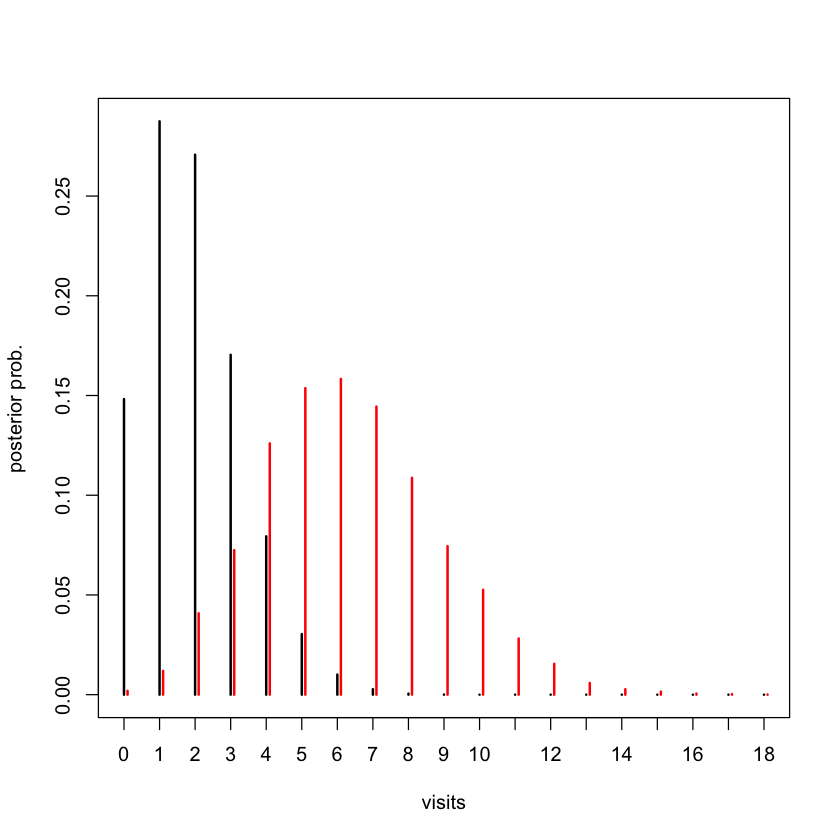

In [30]:
y1 = rpois(n=n_sim, lambda=lam1)
y2 = rpois(n=n_sim, lambda=lam2)

plot(table(factor(y1, levels=0:18))/n_sim, pch=2, ylab="posterior prob.", xlab="visits")
points(table(y2+0.1)/n_sim, col="red")

- 마지막으로, 우리는 원래 질문에 답할 수 있습니다 : 건강이 좋지 않은 사람이 건강이 좋은 사람보다 의사 방문이 더 많이 발생할 확률은 얼마입니까?

In [31]:
mean(y2 > y1)

[1] 0.919

- 시뮬레이션에서 모델 파라미터에 대한 posterior probability을 사용했기 때문에 이 두 명의 새로운 개인에 대한 방문 횟수에 대한 이 posterior predictive distribution는 자연스럽게 모델 추정의 불확실성을 고려합니다. 

- 이것은 MLE 또는 posterior means에서 모델 매개 변수를 수정하고 새 개인에 대한 시뮬레이션 된 데이터를 얻는 것보다 더 정직하고 현실적인 분포입니다.

### Hierarchical Modeling

![title](img/week4_2.png)

- 우리가 만든 모든 모델링에서 우리는 모든 관찰이 독립적이라고 가정했습니다.
- 데이터 포인트에 자연스럽게 그룹화되는 경우가 있는데, 이는 일부 관측 쌍이 다른 관측 쌍보다 서로 유사해야 한다고 생각하게 합니다.
- 초콜릿 칩 쿠키를 생산하는 회사를 소유하고 있다고 가정 해 봅시다. 실험에서는 150 개의 테스트 쿠키를 생성하게됩니다.
- 당신의 위치에서 30 번을하고 네 개의 다른 공장 위치에서 30 번을 한다고 가정해봅시다. 그래서 이것을 5 개 위치에서 30 개씩 씁니다.
- 모든 위치가 초콜릿 칩 쿠키를 만들 때 동일한 제조법을 사용한다고 가정합니다.
- 위치 1의 쿠키가 다른 위치의 배치에 있는 쿠키보다 배치에서 다른 쿠키와 더 유사 할 것으로 기대하십니까? Poisson 모델의 쿠키 간 차이점을 계층적 모델로 설명 할 수 있습니다.
- 포아송의 모델에 대한 원래 완전히 독립적인 모드로 쿠키의 칩 수는 다음과 같습니다. 
- 쿠키의 경우, 람다가 주어진 칩의 수는 평균 람다가 있는 푸 아송 분포에서 평균이 됩니다.
- 카운트에서 그룹화를 인정할 수 있는 한 가지 방법은 각 위치에 대해 서로 다른 람다 매개 변수를 할당하는 것입니다. 그래서, 우리는 위치 의존 모델을 할 것입니다.
- 우연히 l 번째 위치에 있는 i 번째 쿠키는 쿠키 i의 위치에 의존하는 평균 람다를 가진 포아송을 따릅니다. 
- lambda li은 Poisson lambda li과 독립적으로 올 수 있습니다. 여기서 li는 5 개 위치가 있기 때문에 1과 5 사이의 값을 취할 수 있고 i = 1은 최대 150 개입니다. 즉, 쿠키 2가 위치 2에서 오는 경우 li는 2가 될 것입니다. 쿠키의 예상 칩 수는 람다 2가 될 것입니다. 지금까지는 일원 분산 분석 모델과 같습니다.
- 계층적 모델을 만드는 이유는 각각의 람다 매개 변수에 대해 독립적 인 우선 순위를 지정하는 대신, 우리는 추정 할 하이퍼 매개 변수가있는 일반적인 분포에서 온 것으로 가정합니다. 


#### 그래픽 표현
- 독립적인 매개 변수를 사용하여 계층 구조의 맨 위에서 시작할 것입니다. 그래서 우리는 알파에 대한 노트와 베타에 대한 노트를 가지고 있습니다.
- 두 매개 변수에 의존해서, 우리는 모든 람다를 가지고 있습니다. 그래서 lambda 1, lambda 2, lambda 5까지입니다. 물론 각 lambda의 분포는 알파와 베타에 달려 있습니다.
- 여기서 가장 낮은 수준은 각 개별 쿠키를 나타냅니다. 쿠키는 위치 별로 그룹화되어 있습니다. 여기에서 두 번째 수준으로 표시됩니다. 각 위치마다 평균 초콜릿 칩 수에 대한 매개 변수가 있습니다. 5 가지 람다는 이 수준의 데이터로 생각할 수 있기 때문에 이 다섯가지 의미는 일반적인 분포에서 나온 것입니다. 우리는 매개 변수도 추정 할 수 있습니다.

### Lesson 11: Hierarchical modeling

- Let’s fit our hierarhical model for counts of chocolate chips. The data can be found in cookies.dat.

In [32]:
dat = read.table(file="data/cookies.txt", header=TRUE)
head(dat)

chips,location
12,1
12,1
6,1
13,1
12,1
12,1


In [33]:
table(dat$location)


 1  2  3  4  5 
30 30 30 30 30 

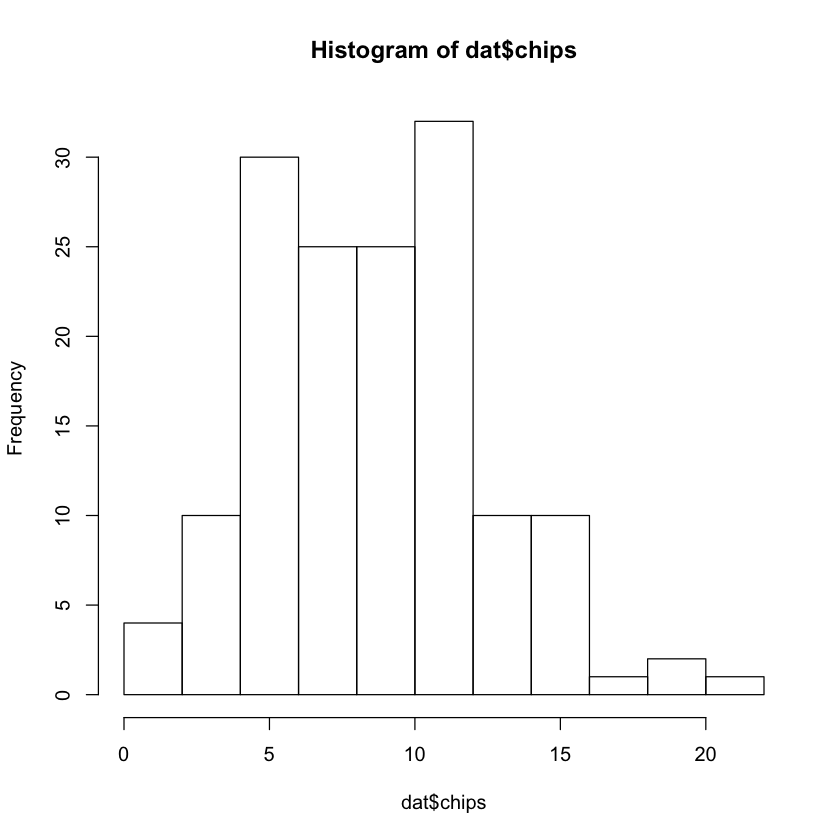

In [34]:
hist(dat$chips)

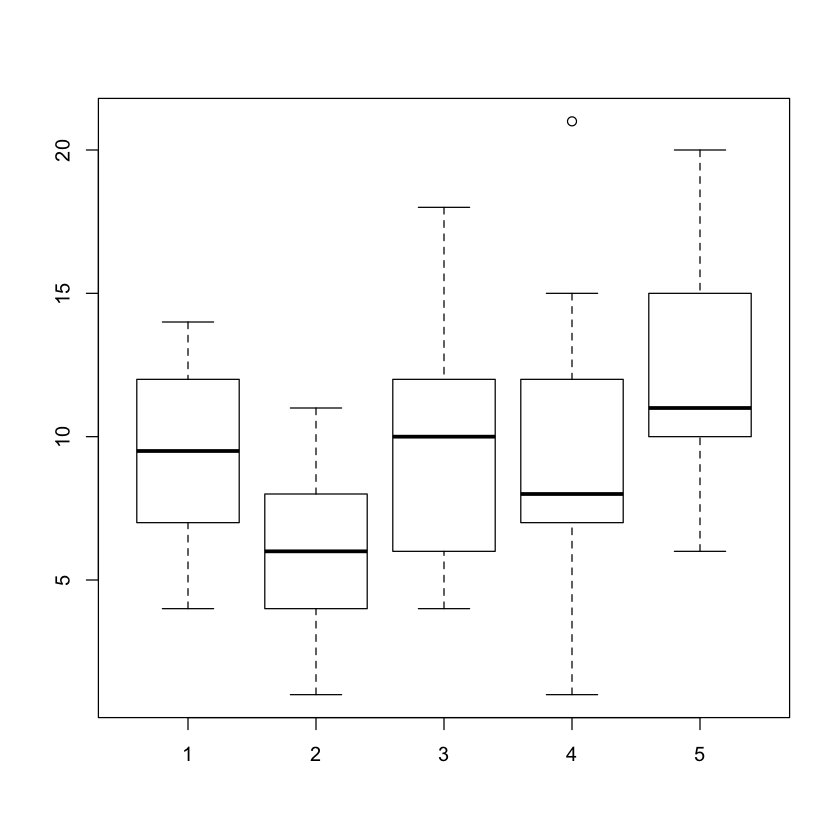

In [35]:
boxplot(chips ~ location, data=dat)

### Prior predictive checks
- 모델을 구현하기 전에 λ 파라미터에 대한 감마 분포를 관리하는 하이퍼 파라미터 인 α 및 β에 대한 사전 분포를 선택해야합니다. 
- 먼저, λ가 무엇을 나타내는 지 생각해보십시오. 위치 j에서, λj는 쿠키 당 예상되는 초콜릿 칩의 수입니다.
- 따라서 α와 β는 위치 간의 이러한 수단의 분포를 제어합니다. 이 감마 분포의 평균은 모든 쿠키에 대한 칩 수의 전체 평균을 나타냅니다.
- 이 감마 분포의 분산은 위치 간의 가변성을 제어합니다. 이 값이 높으면 평균 칩 수는 지역마다 크게 다릅니다. 크기가 작으면 평균 칩 수는 위치에 따라 거의 동일합니다.
- λ의 분포에 대한 다른 사전 매개 변수의 영향을 보려면 시뮬레이션 할 수 있습니다. 우리가 α와 β에 대해 독립적 인 지수 사전을 시도한다고 가정 해 봅시다.

In [36]:
set.seed(112)
n_sim = 500
alpha_pri = rexp(n_sim, rate=1.0/2.0)
beta_pri = rexp(n_sim, rate=5.0)
mu_pri = alpha_pri/beta_pri
sig_pri = sqrt(alpha_pri/beta_pri^2)

summary(mu_pri)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.021    2.983    9.852   61.130   29.980 4859.000 

In [37]:
summary(sig_pri)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.1834    3.3660    8.5490   41.8100   22.2200 2866.0000 

In [38]:
lam_pri = rgamma(n=n_sim, shape=alpha_pri, rate=beta_pri)
summary(lam_pri)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     1.171     7.667    83.060    28.620 11010.000 

In [44]:
length(alpha_pri)

[1] 500

In [45]:
alpha_pri[1:5]

[1] 2.3996746 1.3547368 2.8268651 0.9121076 2.8563480

In [39]:
(lam_pri = rgamma(n=5, shape=alpha_pri[1:5], rate=beta_pri[1:5]))

[1] 66.444084  9.946688  6.028319 15.922568 47.978587

In [40]:
(y_pri = rpois(n=150, lambda=rep(lam_pri, each=30)))

[1] 63 58 64 63 70 62 61 48 71 73 70 77 66 60 72 77 69 62 66 71 49 80 66 75 74
 [26] 55 62 90 65 57 12  9  7 10 12 10 11  7 14 13  9  6  6 13  7 10 12  9  9 10
 [51]  7  8  6  9  7 10 13 13  8 12  6 10  3  6  7  4  6  7  5  5  4  3  6  2  8
 [76]  4  8  4  5  7  1  4  5  3  8  8  3  1  7  3 16 14 13 17 17 12 13 13 16 16
[101] 15 14 11 10 13 17 16 19 16 17 15 16  7 17 21 16 12 15 14 13 52 44 51 46 39
[126] 40 40 44 46 59 45 49 58 42 31 52 43 47 53 41 48 57 35 60 51 58 36 34 41 59

- priors는 분산이 높고 정보가 아니기 때문에 비현실적인 예측 분포를 생성합니다. 여전히 충분한 데이터가 이전의 데이터를 압도하여 유용한 사후 분포가 됩니다. 대안으로, 우리는 이전의 믿음을 적절히 나타낼 때까지 이러한 사전 배포본을 조정 및 시뮬레이션 할 수 있습니다. 또 다른 방법은 이전에 감마를 다시 매개 변수화하는 것입니다.

### Lesson 11.3

In [50]:
mod_string = " model {
for (i in 1:length(chips)) {
  chips[i] ~ dpois(lam[location[i]])
}

for (j in 1:max(location)) {
  lam[j] ~ dgamma(alpha, beta)
}

alpha = mu^2 / sig^2
beta = mu / sig^2

mu ~ dgamma(2.0, 1.0/5.0)
sig ~ dexp(1.0)

} "

In [52]:
set.seed(113)

data_jags = as.list(dat)

params = c("lam", "mu", "sig")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 150
   Unobserved stochastic nodes: 7
   Total graph size: 319

Initializing model



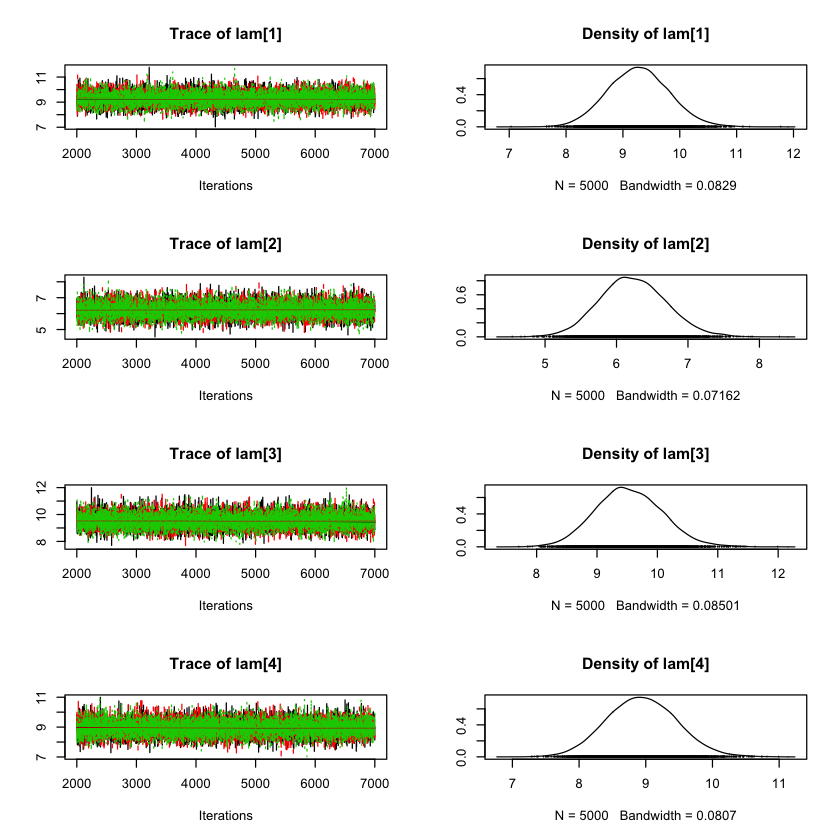

Potential scale reduction factors:

       Point est. Upper C.I.
lam[1]          1          1
lam[2]          1          1
lam[3]          1          1
lam[4]          1          1
lam[5]          1          1
mu              1          1
sig             1          1

Multivariate psrf

1

,lam[1],lam[2],lam[3],lam[4],lam[5],mu,sig
Lag 0,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.0151098554,0.117765862,0.013445204,0.016220386,0.058503726,0.355597118,0.560874292
Lag 5,0.0006793715,-0.003167230,0.013490334,0.008797474,0.009259050,0.020376247,0.072083914
Lag 10,0.0013772619,-0.008906458,0.002853068,0.000441570,0.012563977,0.003612986,0.013094644
Lag 50,-0.0031076178,0.012861232,-0.014939761,0.002602891,-0.004310635,0.016367424,-0.008693718


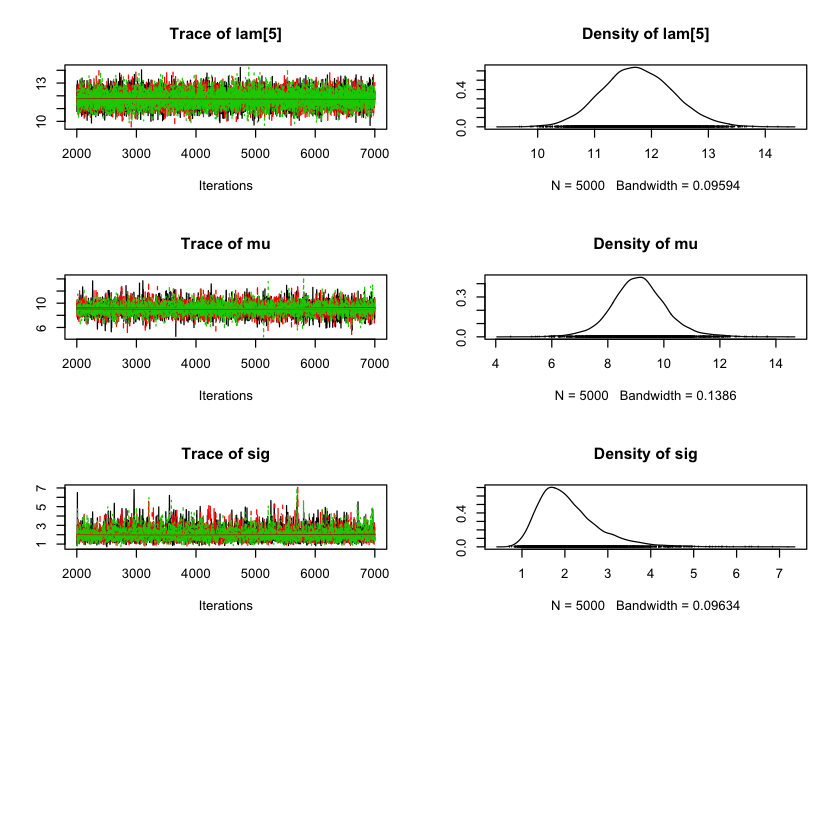

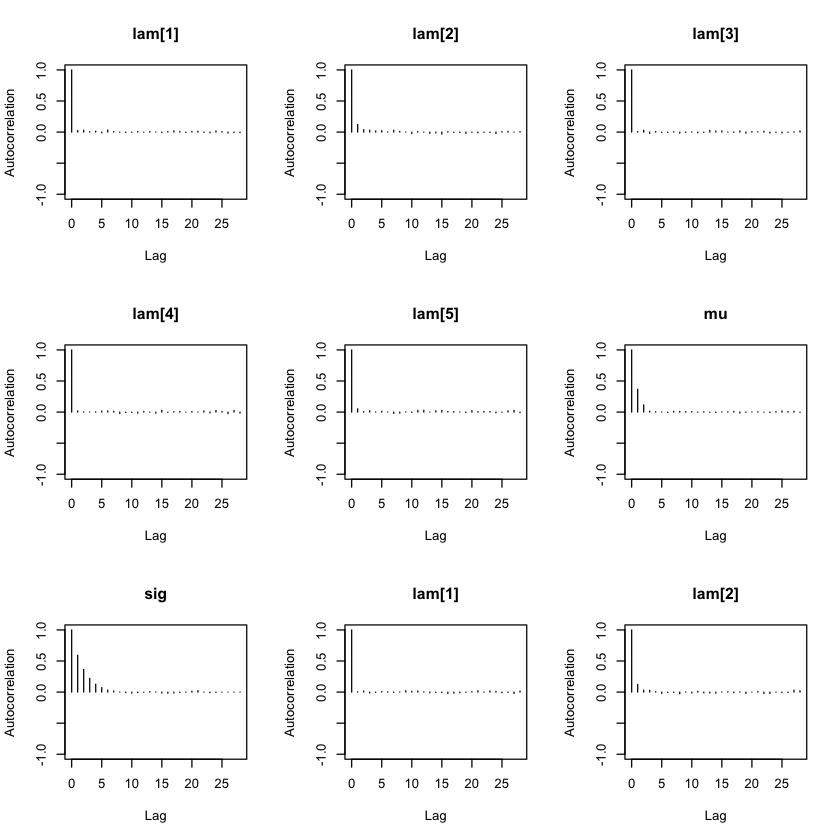

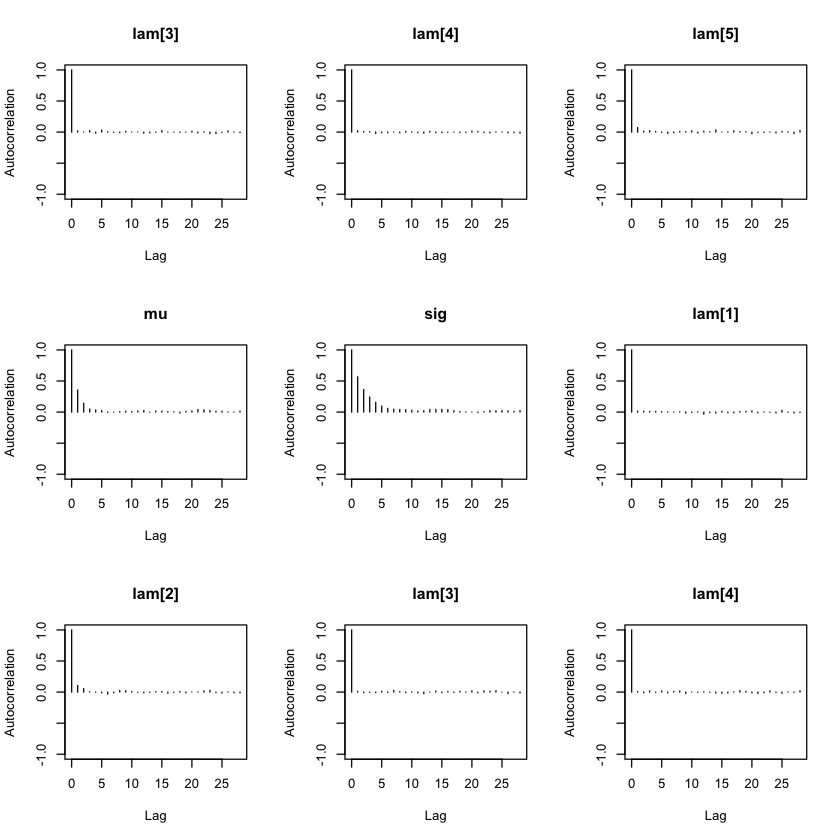

lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
14493.943 11127.529 14264.657 14786.696 13084.799  7254.958  4013.842

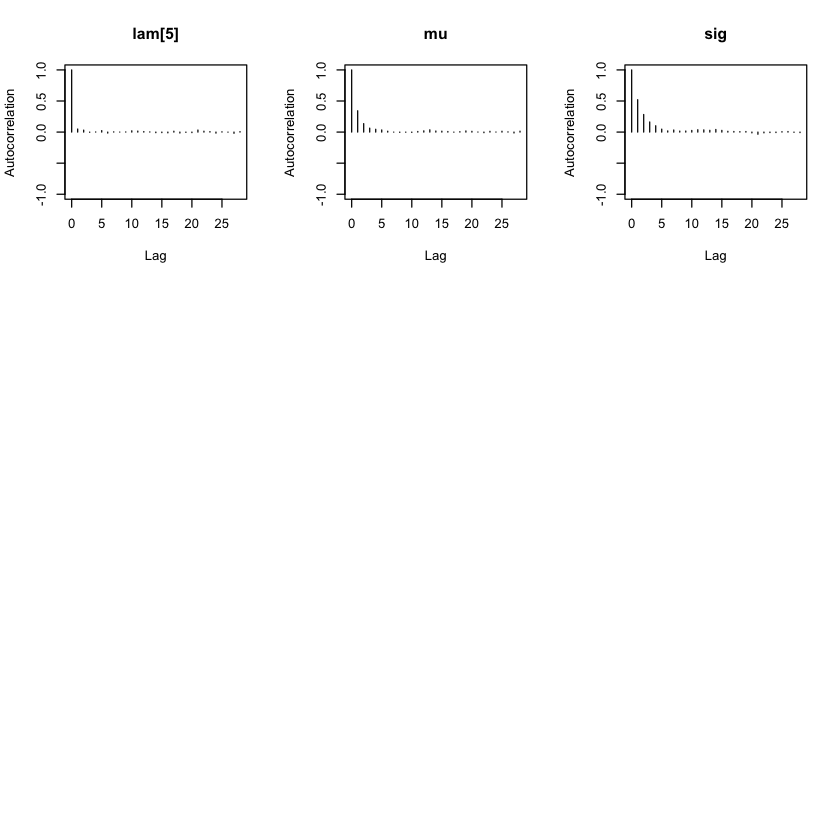

In [53]:
## convergence diagnostics
plot(mod_sim)

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
autocorr.plot(mod_sim)
effectiveSize(mod_sim)

## compute DIC
dic = dic.samples(mod, n.iter=1e3)

### Model checking
- 수렴을 평가한 후 잔차를 통해 적합성을 확인할 수 있습니다. 계층적 모델을 사용하면 관찰 수준과 위치 평균 수준의 두 가지 수준의 잔차가 있습니다. 단순화하기 위해 매개 변수의 posterior 평균과 관련된 잔차를 살펴봄.

- 첫째, 우리는 위치 평균의 추정치에 근거한 관측 잔차를 가지고 있다.

In [54]:
## observation level residuals
(pm_params = colMeans(mod_csim))

lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
 9.274080  6.230421  9.529326  8.942746 11.759747  9.115937  2.075808

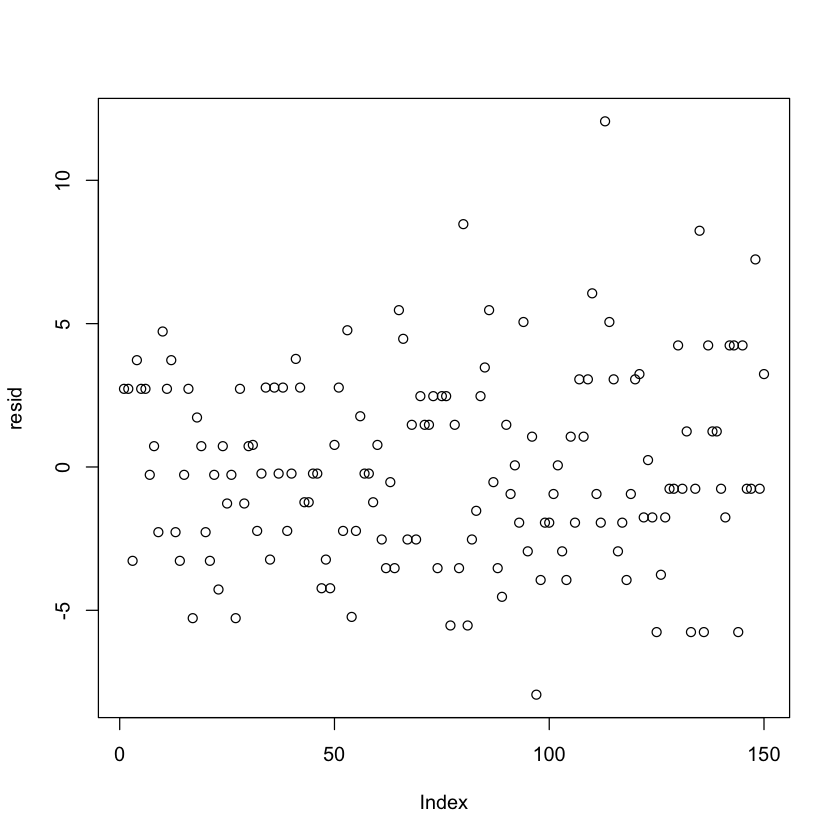

In [55]:
yhat = rep(pm_params[1:5], each=30)
resid = dat$chips - yhat
plot(resid)

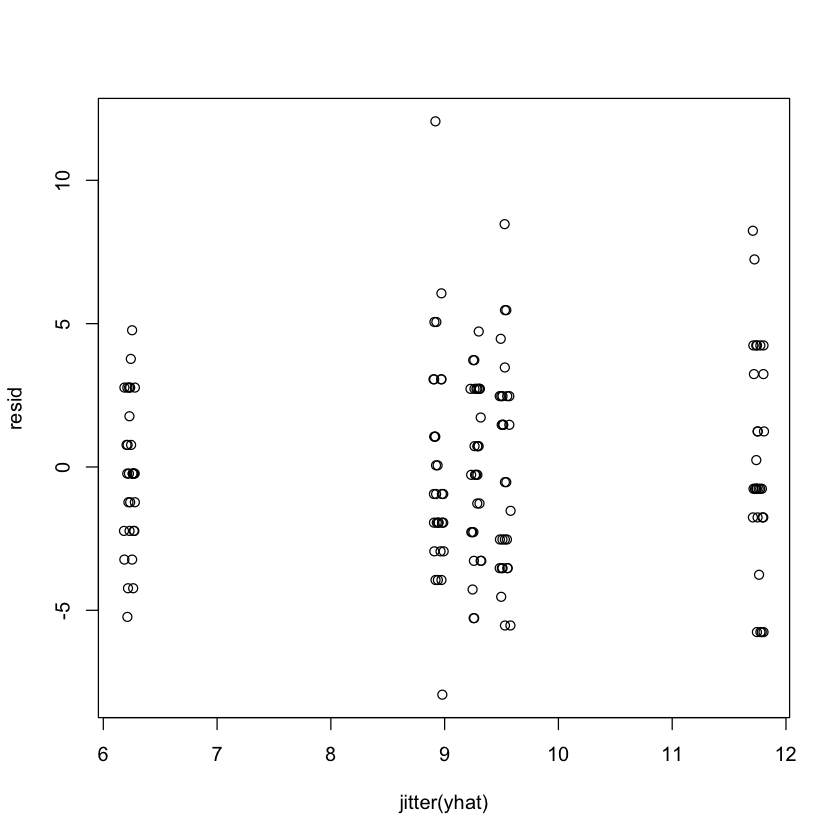

In [56]:
plot(jitter(yhat), resid)

In [57]:
var(resid[yhat<7])

[1] 6.447126

In [58]:
var(resid[yhat>11])

[1] 13.72414

- 우리가 확인할 수있는 또 다른 방법은 그룹의 잔차의 분산을 바로 보도록 하는 것. 
- 그래서 이것은 y hat이 7보다 작은 잔차입니다. 예측 된 값은 6에 가깝기 때문에 6에 가까운 분산을 가져야합니다. 아주 좋습니다. 
- 예상 값이 예를 들어 11보다 큰 경우. 우리는 잔류 분산이 12에 가까울 것으로 기대합니다. 그렇기 때문에 이러한 데이터를 가진이 모델에서 분산 이상은 문제가되지 않는 것으로 보입니다.

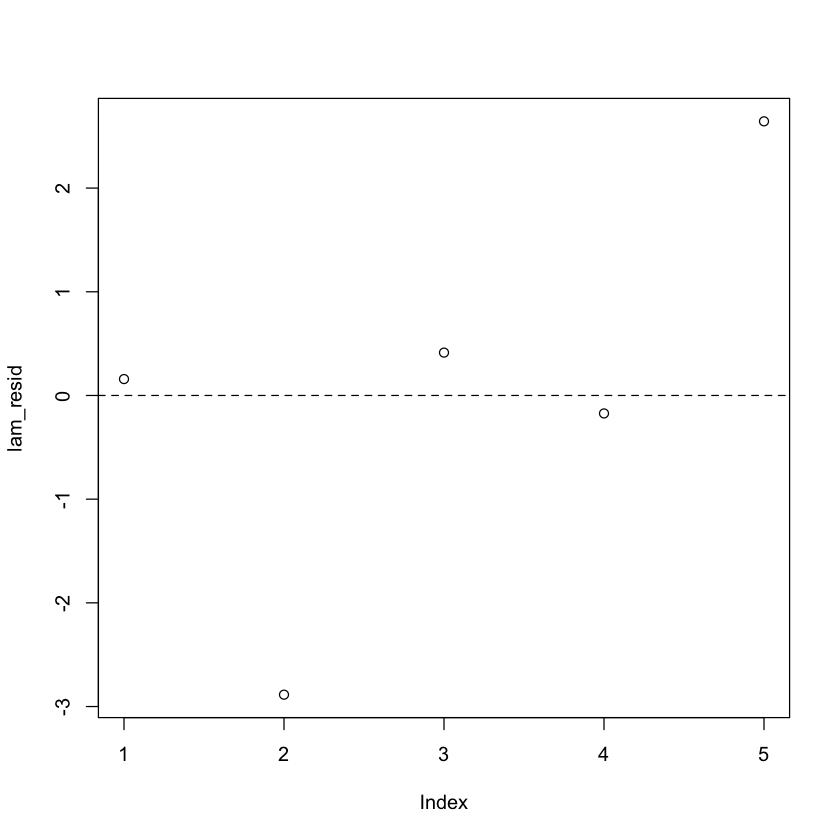

In [59]:
## location level residuals
lam_resid = pm_params[1:5] - pm_params["mu"]
plot(lam_resid)
abline(h=0, lty=2)

- 5 개의 람다를 포함하는 매개 변수 1 ~ 5의 posterior means, 뮤를 빼서 mu 매개 변수의 사후 평균은 람다 잔차입니다. 람다 잔차를 그려 봅시다.
- 이 모델에 대한 가정에 대한 명백한 위반은 없는 것처럼 보입니다.

In [60]:
summary(mod_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
lam[1]  9.274 0.5352 0.004370       0.004454
lam[2]  6.230 0.4623 0.003775       0.004387
lam[3]  9.529 0.5487 0.004480       0.004599
lam[4]  8.943 0.5210 0.004254       0.004286
lam[5] 11.760 0.6193 0.005057       0.005416
mu      9.116 0.9794 0.007997       0.011497
sig     2.076 0.7037 0.005746       0.011212

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lam[1]  8.250  8.904  9.267  9.627 10.341
lam[2]  5.354  5.914  6.217  6.536  7.165
lam[3]  8.500  9.151  9.511  9.896 10.634
lam[4]  7.952  8.581  8.934  9.293  9.989
lam[5] 10.579 11.338 11.744 12.172 13.011
mu      7.177  8.505  9.100  9.703 11.165
sig     1.095  1.583  1.942  2.416  3.791


- 이 5 개의 람다 매개 변수가 위치 수단이라는 것을 기억하십시오. 따라서 쿠키 당 평균 칩 수는 위치에 따라 어떻게 달라지는 지 확인할 수 있습니다.
- Mu와 시그마는 계층 구조에서 다음 레벨을 말해줍니다. 이것은 모든 위치에 대해 예상되는 칩 수의 글로벌 평균으로 해석되며 약 9.1입니다. 
- 그리고 여기 시그마는 이러한 람다의 표준 편차, 다른 위치를 위한 평균의 편차입니다. 그래서 이것은 위치가 서로 다른 경향이 얼마나 많은지 말해줍니다. 물론이 요약으로부터 사후 확률 간격을 생성 할 수 있습니다. 또는 Monte Carlo 샘플을 사용하여 다른 가설의 사후 확률을 테스트 할 수 있습니다.

### Lesson 11.4 Posterior predictive simulation

- 우리가 사전 분포에서 했던 것처럼, 우리는 이러한 사후 샘플을 사용하여 우리를 posterior predictive distribution에 관심을 갖는 몬테카를로 추정치를 얻을 수 있습니다.

- 예를 들어 μ 및 σ의 사후 분포에서 끌어와 새로운 위치에 대한 평균의 사후 예측 분포를 시뮬레이션 할 수 있습니다.

In [61]:
(n_sim = nrow(mod_csim))

[1] 15000

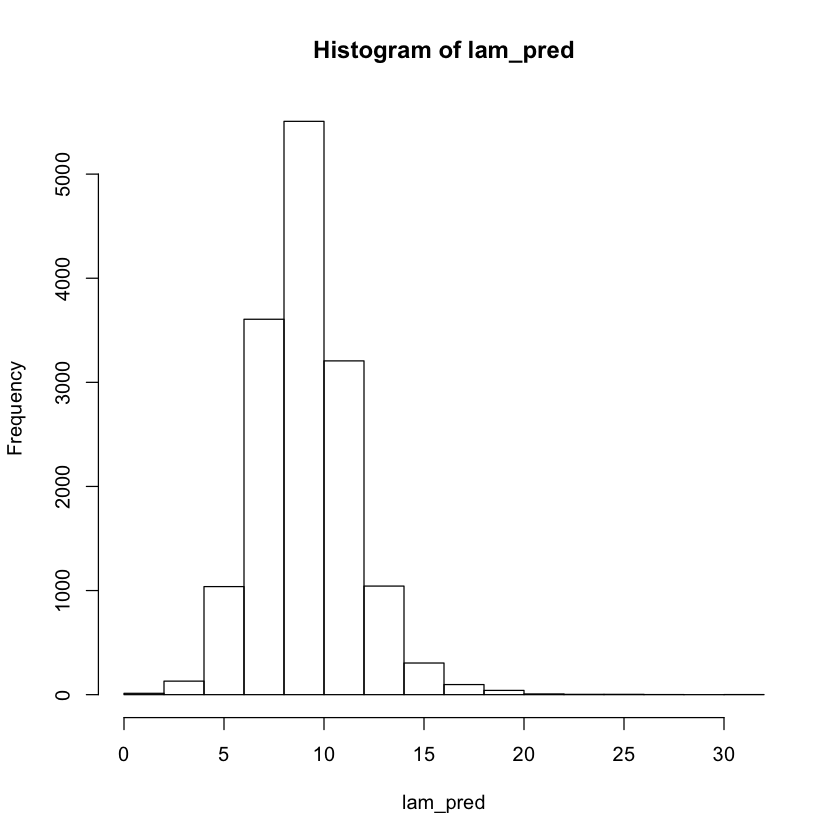

In [62]:
lam_pred = rgamma(n=n_sim, shape=mod_csim[,"mu"]^2/mod_csim[,"sig"]^2, 
                  rate=mod_csim[,"mu"]/mod_csim[,"sig"]^2)
hist(lam_pred)

In [63]:
mean(lam_pred > 15)

[1] 0.0176

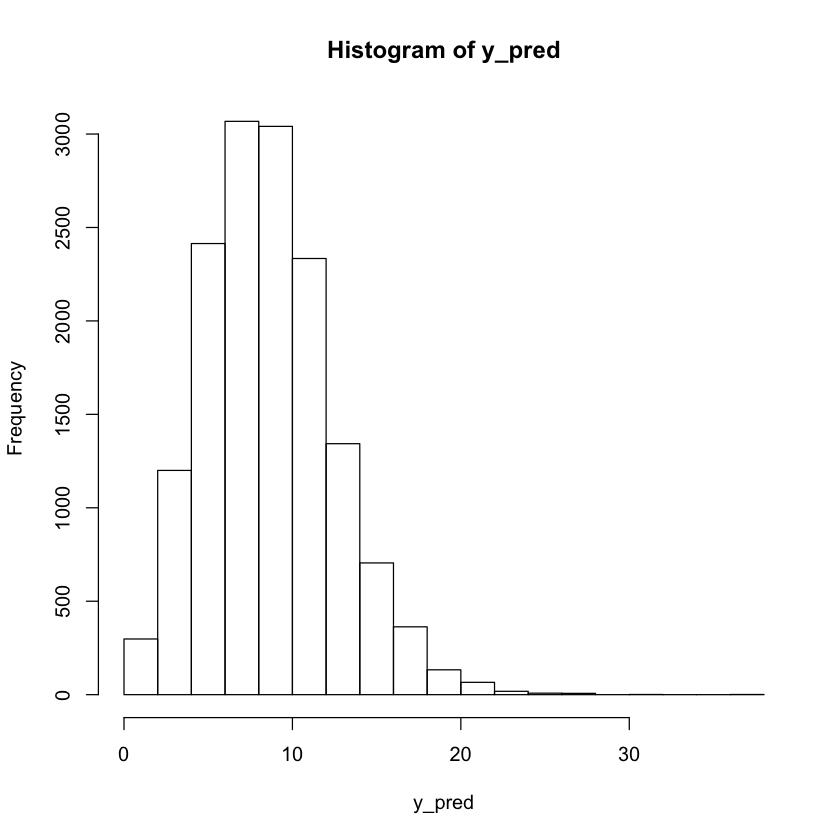

In [64]:
y_pred = rpois(n=n_sim, lambda=lam_pred)
hist(y_pred)

In [65]:
mean(y_pred > 15)

[1] 0.05793333

- 마지막으로 다음과 같은 질문에 답할 수 있습니다. 위치 1에서 생성 된 다음 쿠키의 칩 수가 7 개 미만인 사후 확률은 얼마입니까?

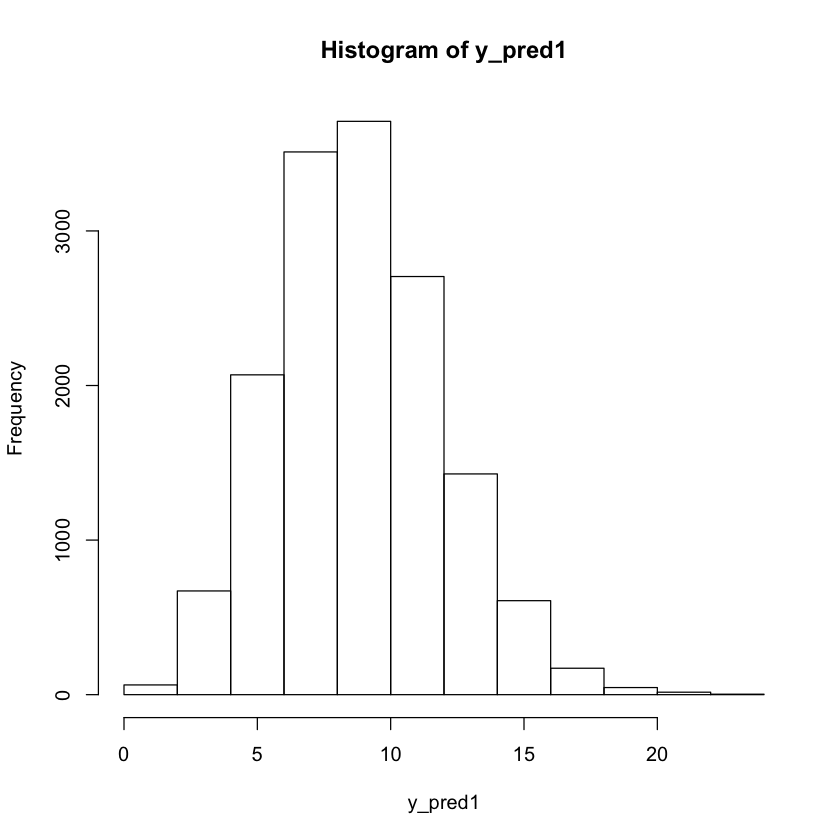

In [66]:
y_pred1 = rpois(n=n_sim, lambda=mod_csim[,"lam[1]"])
hist(y_pred1)

In [67]:
mean(y_pred1 < 7)

[1] 0.1868667

### Lesson 11.6 Random intercept linear model
- 우리는 지역 변수를 통합하여 유아 사망률에 대한 Leinhardt 데이터의 선형 모델을 확장 할 수 있습니다. 각 지역마다 intercept가 있는 계층 적 모델을 통해 이를 수행 할 것입니다.

In [68]:
library("car")
data("Leinhardt")
#?Leinhardt
str(Leinhardt)

'data.frame':	105 obs. of  4 variables:
 $ income: int  3426 3350 3346 4751 5029 3312 3403 5040 2009 2298 ...
 $ infant: num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ region: Factor w/ 4 levels "Africa","Americas",..: 3 4 4 2 4 4 4 4 4 4 ...
 $ oil   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


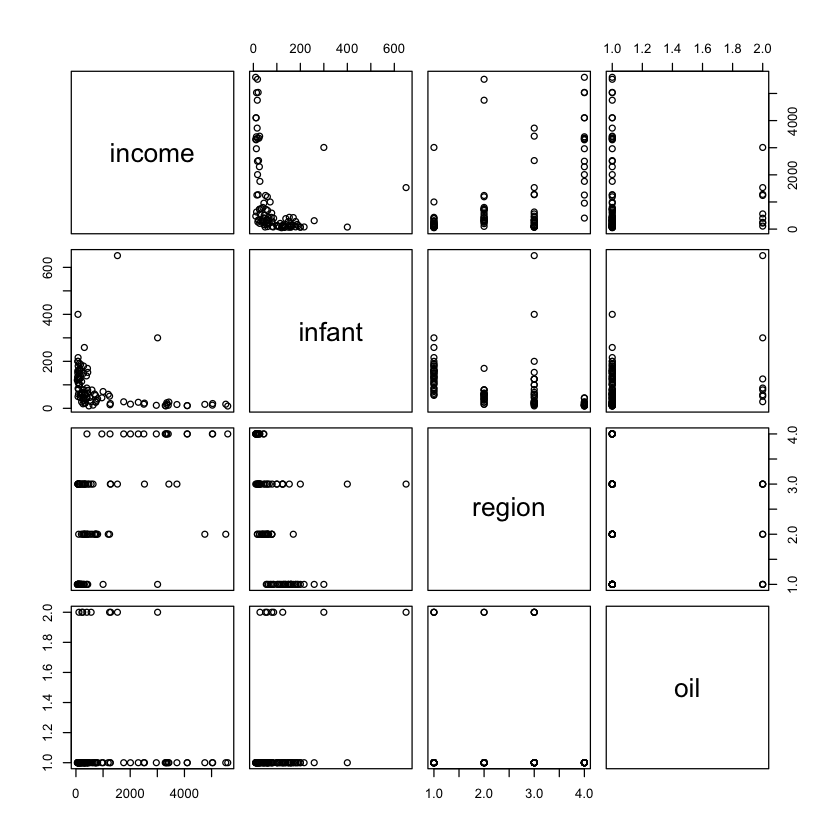

In [69]:
pairs(Leinhardt)

In [70]:
head(Leinhardt)

,income,infant,region,oil
Australia,3426,26.7,Asia,no
Austria,3350,23.7,Europe,no
Belgium,3346,17.0,Europe,no
Canada,4751,16.8,Americas,no
Denmark,5029,13.5,Europe,no
Finland,3312,10.1,Europe,no


In [71]:
dat = na.omit(Leinhardt)
dat$logincome = log(dat$income)
dat$loginfant = log(dat$infant)
str(dat)

'data.frame':	101 obs. of  6 variables:
 $ income   : int  3426 3350 3346 4751 5029 3312 3403 5040 2009 2298 ...
 $ infant   : num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ region   : Factor w/ 4 levels "Africa","Americas",..: 3 4 4 2 4 4 4 4 4 4 ...
 $ oil      : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ logincome: num  8.14 8.12 8.12 8.47 8.52 ...
 $ loginfant: num  3.28 3.17 2.83 2.82 2.6 ...
 - attr(*, "na.action")=Class 'omit'  Named int [1:4] 24 83 86 91
  .. ..- attr(*, "names")= chr [1:4] "Iran" "Haiti" "Laos" "Nepal"


In [72]:
library("rjags")

mod_string = " model {
  for (i in 1:length(y)) {
    y[i] ~ dnorm(mu[i], prec)
    mu[i] = a[region[i]] + b[1]*log_income[i] + b[2]*is_oil[i]
  }
  
  for (j in 1:max(region)) {
    a[j] ~ dnorm(a0, prec_a)
  }
  
  a0 ~ dnorm(0.0, 1.0/1.0e6)
  prec_a ~ dgamma(1/2.0, 1*10.0/2.0)
  tau = sqrt( 1.0 / prec_a )
  
  for (j in 1:2) {
    b[j] ~ dnorm(0.0, 1.0/1.0e6)
  }
  
  prec ~ dgamma(5/2.0, 5*10.0/2.0)
  sig = sqrt( 1.0 / prec )
} "

In [74]:
set.seed(116)
data_jags = list(y=dat$loginfant, log_income=dat$logincome,
                  is_oil=as.numeric(dat$oil=="yes"), region=as.numeric(dat$region))
data_jags$is_oil
table(data_jags$is_oil, data_jags$region)

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

   
     1  2  3  4
  0 31 20 24 18
  1  3  2  3  0

In [75]:
params = c("a0", "a", "b", "sig", "tau")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3) # burn-in

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 9
   Total graph size: 639

Initializing model



In [76]:
mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)

mod_csim = as.mcmc(do.call(rbind, mod_sim)) # combine multiple chains

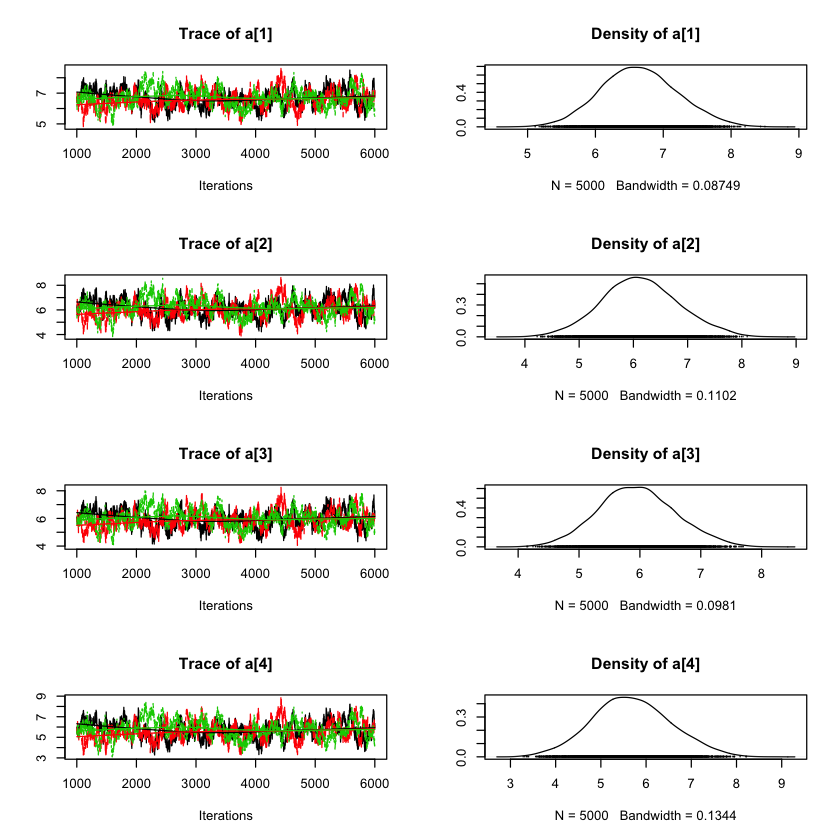

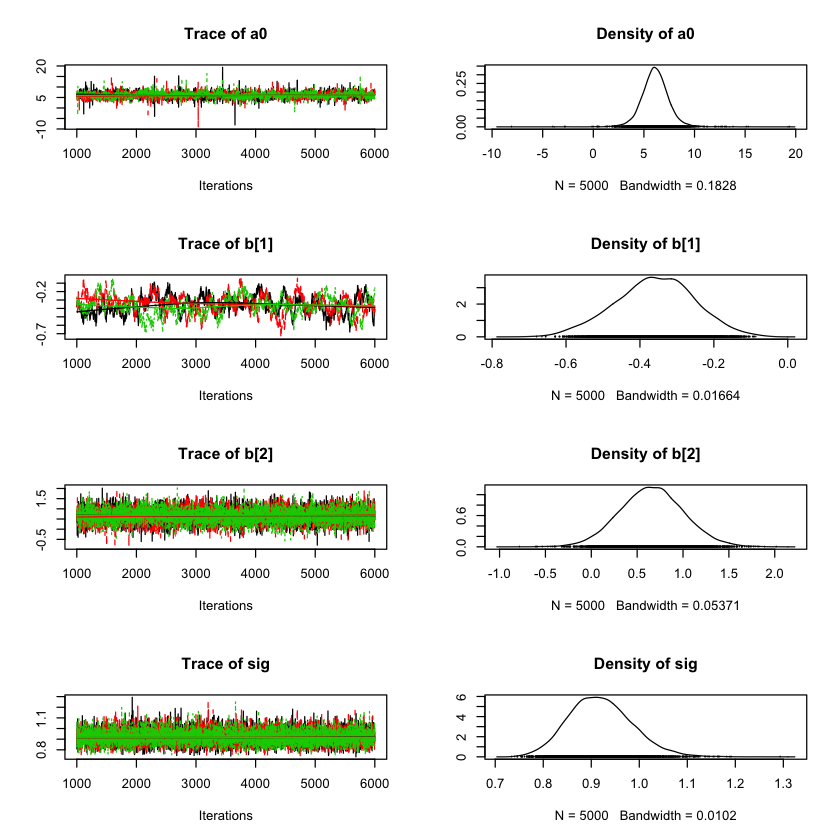

Potential scale reduction factors:

     Point est. Upper C.I.
a[1]          1       1.01
a[2]          1       1.01
a[3]          1       1.01
a[4]          1       1.01
a0            1       1.00
b[1]          1       1.01
b[2]          1       1.00
sig           1       1.00
tau           1       1.01

Multivariate psrf

1

,a[1],a[2],a[3],a[4],a0,b[1],b[2],sig,tau
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.00000000,1.000000000,1.000000000
Lag 1,0.9204047,0.9252336,0.9219399,0.9384691,0.26191941,0.9806900,0.13930227,0.057581341,0.296212042
Lag 5,0.8551641,0.8611379,0.8551265,0.8722389,0.23041818,0.9111943,0.01621870,0.028966564,-0.011310559
Lag 10,0.7803876,0.7874547,0.7829762,0.7957645,0.21721153,0.8326308,0.03855287,0.010251147,0.009389163
Lag 50,0.3674276,0.3674956,0.3687176,0.3747808,0.09740599,0.3911508,0.00890705,0.007118534,-0.015720683


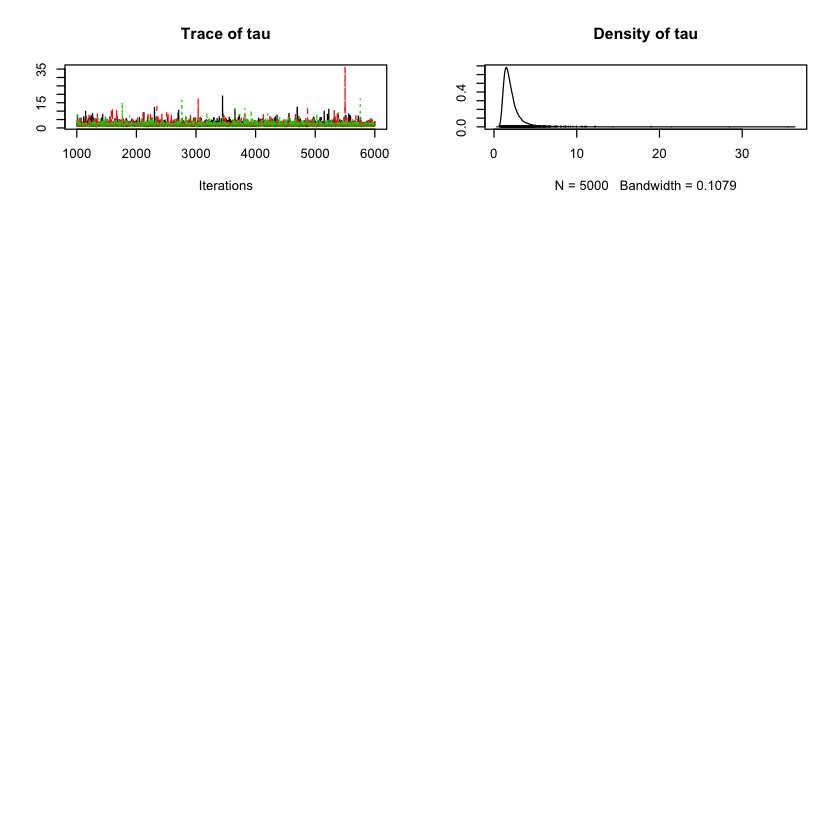

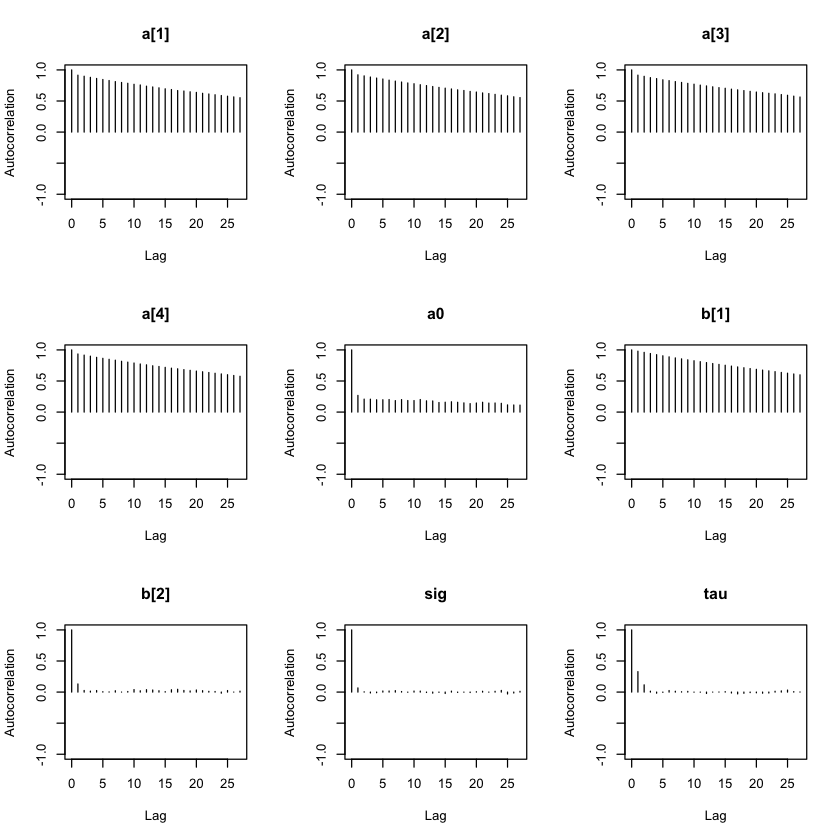

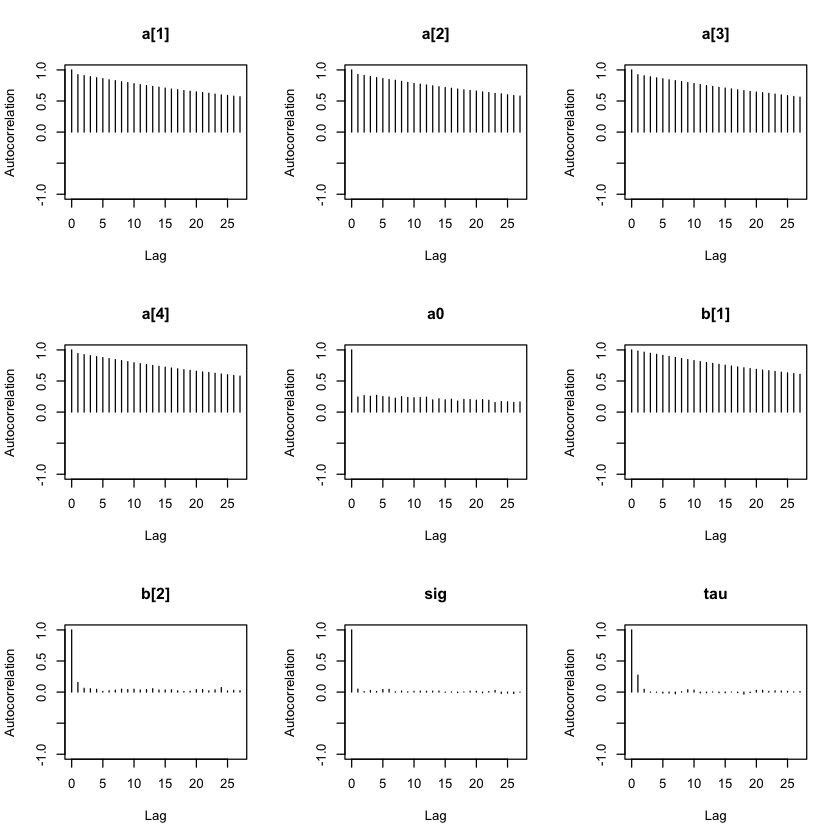

a[1]       a[2]       a[3]       a[4]         a0       b[1]       b[2] 
  147.9238   146.3145   147.8893   142.3558   626.7889   138.0684  5745.6704 
       sig        tau 
11472.7296  8444.3770

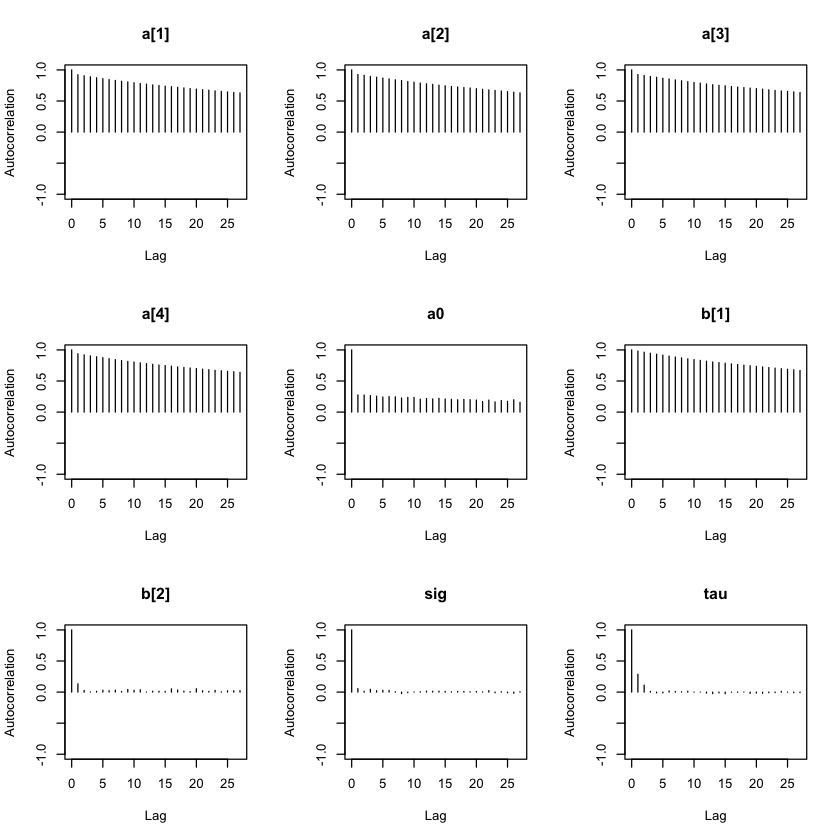

In [77]:
## convergence diagnostics
plot(mod_sim)

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
autocorr.plot(mod_sim)
effectiveSize(mod_sim)

### 결과
- 컨버전스는 괜찮아 보입니다. 따라서 DIC를 사용하여 7 단원의 이전 모델과 비교해 봅시다.

In [78]:
dic.samples(mod, n.iter=1e3)
## nonhierarchical model: 230.1

Mean deviance:  213.9 
penalty 7.125 
Penalized deviance: 221.1 

- 이 모델은 우리가 이전에 적합했던 비 계층 적 모델보다 개선 된 것으로 보입니다. 
- "유효"매개 변수 수로 해석 할 수 있는 패널티 항목은 실제 매개 변수 수 (9 개)보다 적습니다. 
- 계층 구조에서 정보를 "공유"하거나 서로 차용하기 때문에 "효과적인"매개 변수가 적습니다.
- 계층 구조를 건너 뛰고 하나의 intercept를 맞추면 네 개의 매개 변수가 생깁니다. 우리가 각 지역에 대해 독립적인 인터셉트를 적절히 수용했다면 7 개의 매개 변수가 생겼을 것입니다.

In [79]:
summary(mod_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD  Naive SE Time-series SE
a[1]  6.6477 0.5648 0.0046115      0.0461885
a[2]  6.1316 0.7116 0.0058099      0.0588053
a[3]  5.9534 0.6332 0.0051704      0.0520124
a[4]  5.6814 0.8679 0.0070861      0.0723378
a0    6.1060 1.3546 0.0110603      0.0541998
b[1] -0.3597 0.1074 0.0008771      0.0091257
b[2]  0.6585 0.3491 0.0028506      0.0047324
sig   0.9193 0.0659 0.0005381      0.0006178
tau   2.0468 1.0993 0.0089754      0.0119510

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
a[1]  5.58369  6.2576  6.6319  7.0198  7.786
a[2]  4.75785  5.6472  6.1107  6.6004  7.588
a[3]  4.73590  5.5200  5.9379  6.3727  7.238
a[4]  4.00797  5.0849  5.6526  6.2598  7.436
a0    3.49103  5.3164  6.0955  6.8980  8.759
b[1] -0.57848 -0.4307 -0.3569 -0.2864 -0.154
b[2]

- 이 특별한 모델에서, 절편은 기름을 생산하지 않는 나라의 평균 반응에 해당하고 1 인당 수입이 0 달러 (1 인당 1 달러 수입)이기 때문에 실제 해석이 없습니다. a0를 전반적인 평균 절편으로, τ를 절편의 표준 편차로 해석 할 수 있습니다.

### 기타 모델
- 적절한 상호 작용 용어를 추가하는 방법을 조사하지 않았습니다.
- 우리는 단지 절편에 계층 구조를 추가하는 것을 고려했지만 실제로는 수입과 석유에 대한 계수와 같은 모델의 다른 용어에 대해서도 같은 것을 하지 못합니다. 
- 우리는 이러한 대안 중 일부 또는 전부를 시도해 볼 수 있으며 DIC가 그러한 모델에 어떻게 변화 하는지를 볼 수 있습니다. 
- 이것은 우리가 논의한 다른 모델 검사 기술과 함께 추론 및 예측을 수행하는 데 사용할 수있는 최상의 모델을 식별하는 데 사용될 수 있습니다.

### Lesson 11H: Mixture models
- 데이터의 막대 그래프는 종종 표준 확률 분포를 따르지 않는다는 것을 나타냅니다. 
- 때로는 다른 값을 설명하기위한 설명 변수 (또는 공변량)가 있으며 정상 회귀와 마찬가지로 정규 분포 오류가 적절합니다. 
- 그러나 데이터 값 자체와 공변량 만있는 경우 데이터에 비표준 분포를 맞추어야 할 수도 있습니다. 수행하는 한 가지 방법은 표준 배포판을 혼합하는 것입니다.

- 혼합 분포는 확률 분포의 가중치 조합입니다. 예를 들어, mean 1과 normal distribution이 평균 3이고 분산이 1 인 지수 분포를 취할 수 있습니다 (일반적으로 두 개의 혼합 구성 요소가 동일한 지원을 가지지 만 여기에서 지수 구성 요소는 음수가 아니어야하며 일반 구성 요소는 긍정 또는 부정). 
- 지수 분포의 경우 0.4, 정규 분포의 경우 0.6입니다. 이 배포판의 PDF를 다음과 같이 작성할 수 있습니다.

$$PDF .  p(y) = 0.4 \cdot \exp(-y) \cdot I_{(y \ge 0)} + 0.6 \cdot \frac{1}{\sqrt{2 \pi}} \exp\left(- \frac{1}{2} (y - 3)^2\right) \, .$$

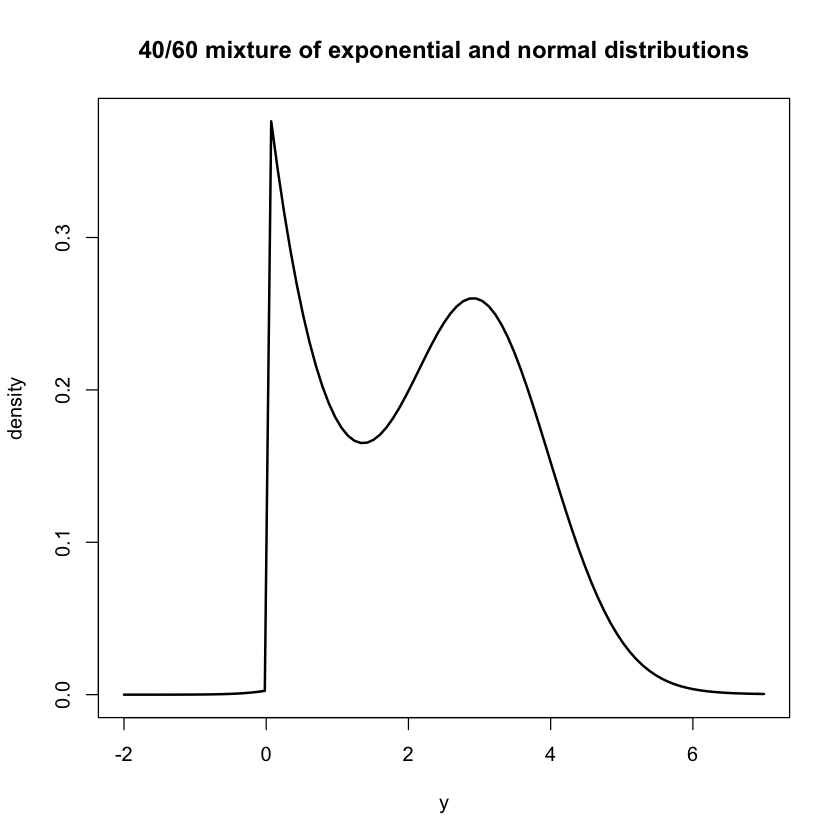

In [80]:
curve( 0.4*dexp(x, 1.0) + 0.6*dnorm(x, 3.0, 1.0), from=-2.0, to=7.0, ylab="density", xlab="y", main="40/60 mixture of exponential and normal distributions", lwd=2)

- 우리는이 두 분포를 지수 분포를 따르는 정규 분포와 정규 분포를 따르는 두 개의 다른 집단을 지배하는 것으로 생각할 수 있습니다.
- 각 모집단에 대해 가중치 적용 PDF를 그려 봅시다.

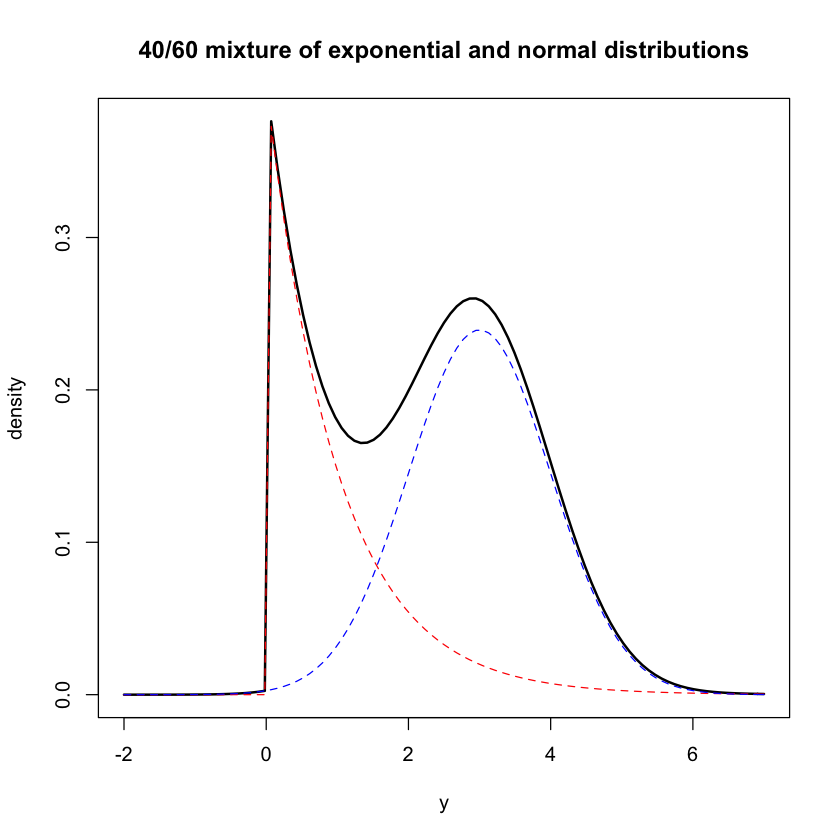

In [81]:
curve( 0.4*dexp(x, 1.0) + 0.6*dnorm(x, 3.0, 1.0), from=-2.0, to=7.0, ylab="density", xlab="y", main="40/60 mixture of exponential and normal distributions", lwd=2)
curve( 0.4*dexp(x, 1.0), from=-2.0, to=7.0, col="red", lty=2, add=TRUE)
curve( 0.6*dnorm(x, 3.0, 1.0), from=-2.0, to=7.0, col="blue", lty=2, add=TRUE)

- The general form for a discrete mixture of distributions is as follows:
$$ p(y) = \sum_{j=1}^J \omega_j \cdot f_j (y) $$

- where the ω’s are positive weights that add up to 1 (they are probabilities) and each of the J fj(y) functions is a PDF for some distribution. In the example above, the weights were 0.4 and 0.6, f1 was an exponential PDF and f2 was a normal PDF.

- 혼합 분포에서 시뮬레이션하는 한 가지 방법은 계층 적 모델을 사용하는 것입니다. 먼저 우리는 다음 관찰이 가중치 ω를 사용함으로써 오는 "모집단"에 대한 지표를 시뮬레이션합니다. 이 zi라고 부르 자. 위의 예에서 zi는 확률값 0.4와 2 (정규 분포를 나타냄)와 확률 0.6의 값 1 (지수 분포를 나타냄)을 취합니다. 다음으로 zi에 해당하는 분포로부터 관측 yi를 시뮬레이트합니다.

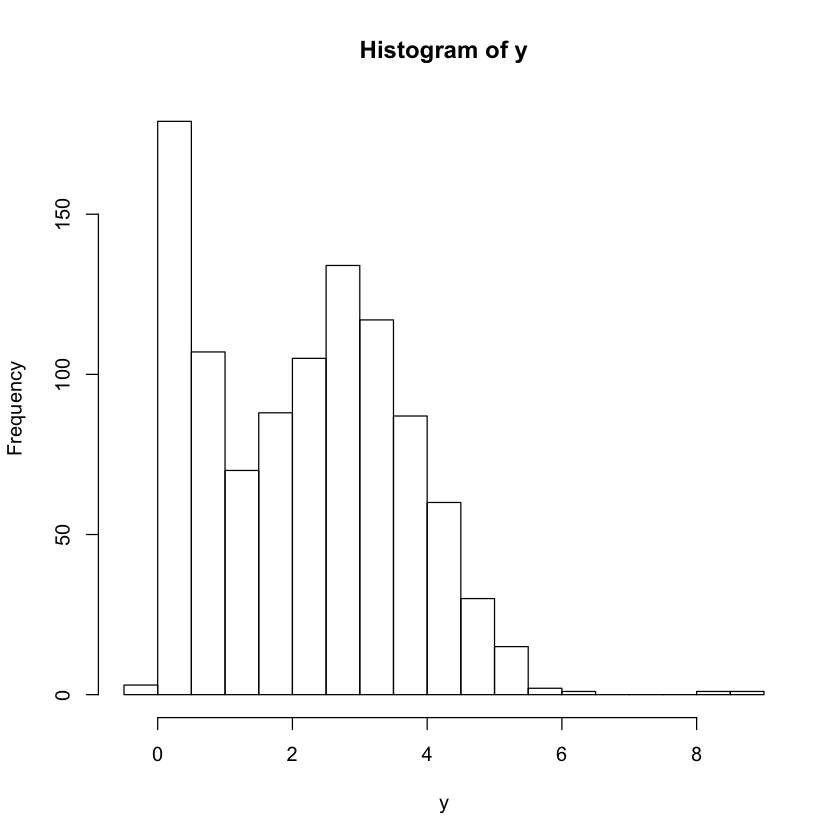

In [82]:
set.seed(117)
n = 1000
z = numeric(n)
y = numeric(n)
for (i in 1:n) {
  z[i] = sample.int(2, 1, prob=c(0.4, 0.6)) # returns a 1 with probability 0.4, or a 2 with probability 0.6
  if (z[i] == 1) {
    y[i] = rexp(1, rate=1.0)
  } else if (z[i] == 2) {
    y[i] = rnorm(1, mean=3.0, sd=1.0)
  }
}
hist(y, breaks=30)

- y 값만 유지하고 z 값을 버리면 위의 혼합물 모델의 샘플이 있습니다. 그것들이 동일하다는 것을 알기 위해 우리는 y와 z의 공동 분포를 무시할 수 있습니다.
$$ p(y) = \sum_{j=1}^2 p(y, z=j) = \sum_{j=1}^2 p(z=j) \cdot p(y \mid z=j) = \sum_{j=1}^2 \omega_j \cdot f_j(y) \, . $$

### Bayesian inference for mixture models
- 혼합 모델을 데이터에 적용 할 때 대개 y 값만 있고 어떤 "모집단"에 속하는지 모릅니다. 
- z 변수는 관찰되지 않기 때문에 unobserved 변수라고합니다. 계층 모델에서 매개 변수로 취급하고 베이지안 추론을 수행 할 수 있습니다. 계층 구조 모델은 다음과 같이 보일 수 있습니다.

$$ \begin{align}
y_i \mid z_i, \theta & \overset{\text{ind}}{\sim} f_{z_i}(y \mid \theta) \, , \quad i = 1, \ldots, n \\
\text{Pr}(z_i = j \mid \omega) &= \omega_j \, , \quad j=1, \ldots, J \\
\omega &\sim p(\omega) \\
\theta &\sim  p(\theta)
\end{align}
$$

- 여기에서 우리는 θ의 집단 특유의 매개 변수에 대한 가중치 벡터 ω와 공역 사전을 위해 사전에 Dirichlet (보충 자료의 배포 검토 참조)을 사용할 수 있습니다. 

- 이 모델을 사용하여 z (관측의 모집단 구성원 수), ω (모집단 가중치) 및 θ (fj의 모집단 특정 매개 변수)에 대한 사후 분포를 얻을 수 있습니다. 다음으로 JAGS에 두 개의 정규 분포를 혼합하는 방법을 살펴 보겠습니다.

### Example with JAGS
- For this example, we will use the data in the attached file 𝚖𝚒𝚡𝚝𝚞𝚛𝚎.𝚌𝚜𝚟mixture.csv.

In [83]:
dat = read.csv("data/mixture.csv", header=FALSE)
y = dat$V1
(n = length(y))

[1] 200

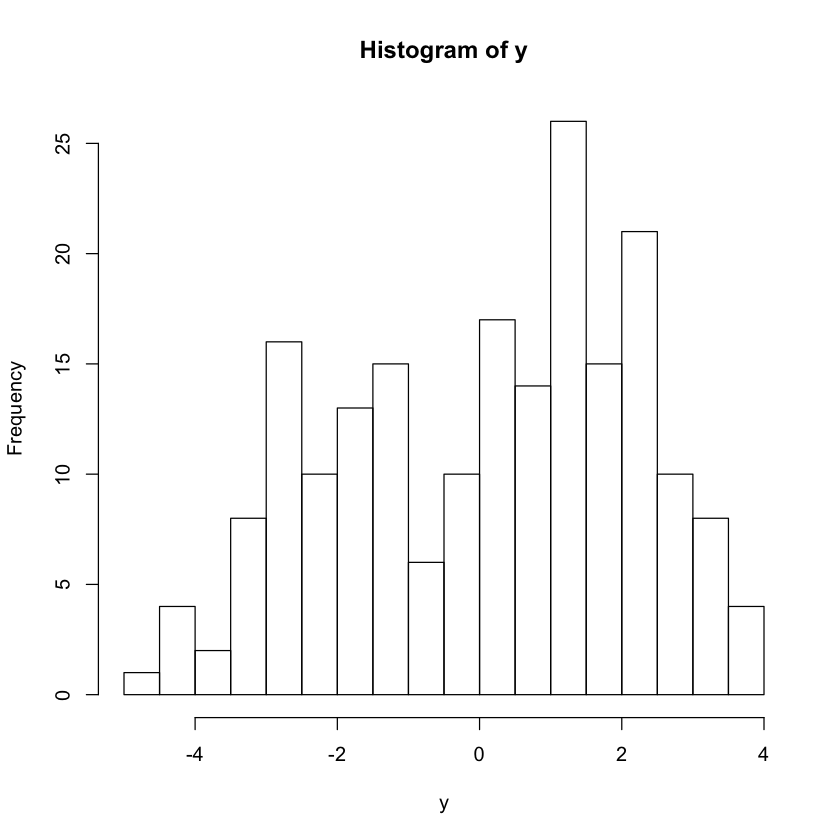

In [84]:
hist(y, breaks=20)

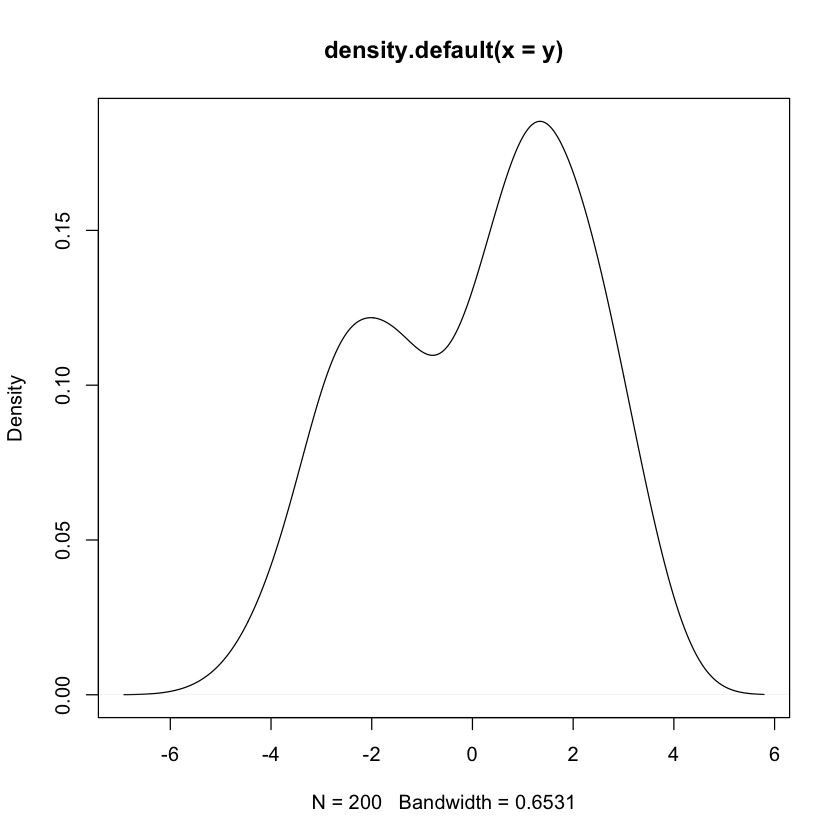

In [85]:
plot(density(y))

- 우리에게는 두 개의 개체군이 있지만, 각 개체군이 어느 개체군에 속해 있는지 알 수 없습니다. 우리는 혼합 가중치 및 베이 즈별 계층 적 모델을 가진 모집단 특정 매개 변수와 함께 이것을 배울 수 있습니다.

- 우리는 분산 1과 다른 (그리고 알려지지 않은) 평균의 두 정규 분포를 혼합하여 사용할 것입니다.

In [86]:
# Model
mod_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[z[i]], prec)
      z[i] ~ dcat(omega)
    }
  
  mu[1] ~ dnorm(-1.0, 1.0/100.0)
    mu[2] ~ dnorm(1.0, 1.0/100.0) T(mu[1],) # ensures mu[1] < mu[2]

    prec ~ dgamma(1.0/2.0, 1.0*1.0/2.0)
  sig = sqrt(1.0/prec)
    
    omega ~ ddirich(c(1.0, 1.0))
} "

- T(?) <- 이것은 mu [2]가 mu [1]보다 크다는 것을 보장 할 것이며, 우리의 혼합 모델을 돕습니다. 때로는 혼합 모델은 식별 가능성 문제에 취약합니다. 
- 어떤 그룹이 어떤 그룹인지는 알 수 없으며, 레이블은 그룹 1과 그룹 2 사이를 전환 할 수 있습니다. 우리가 무스를 주문하도록 강요하고 그들에게 자신을 식별시키는 데 도움이되는 사전을 주면 식별 가능성 문제를 피할 수 있습니다.

In [90]:
set.seed(11)

data_jags = list(y=y)

params = c("mu", "sig", "omega", "z[1]", "z[31]", "z[49]", "z[6]") # Select some z's to monitor

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 204
   Total graph size: 629

Initializing model



In [91]:
mod_sim = coda.samples(model=mod,
                        variable.names=params,
                        n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

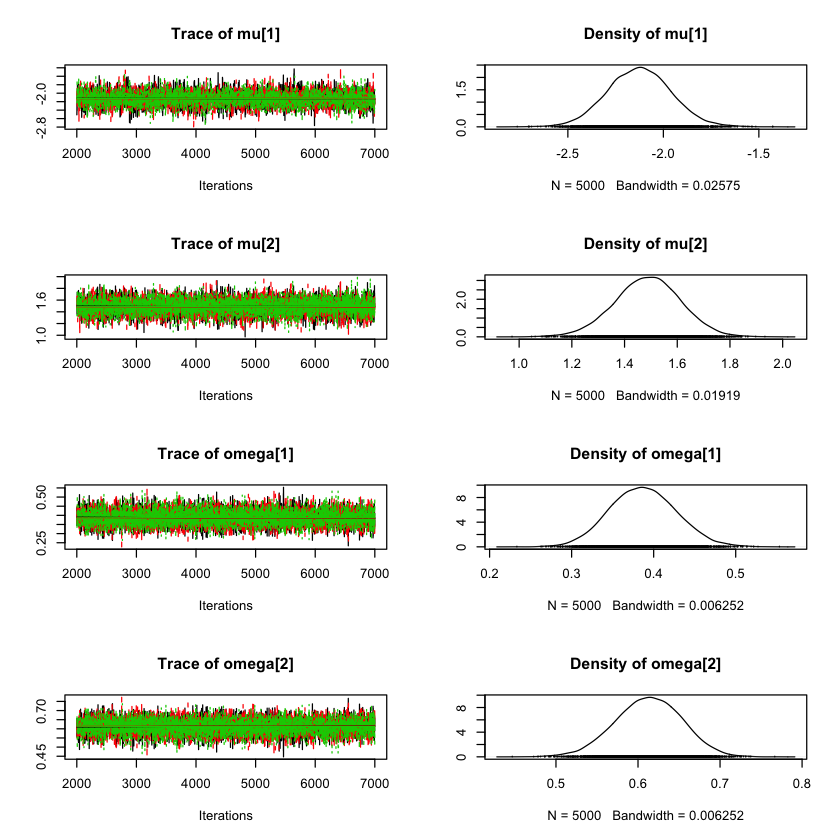

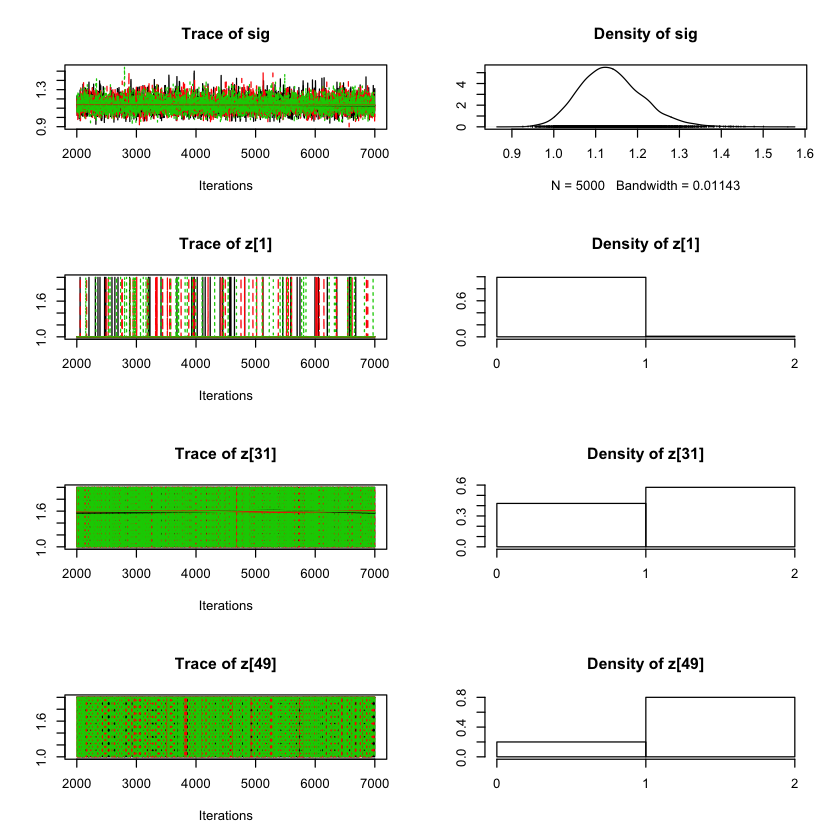

,mu[1],mu[2],omega[1],omega[2],sig,z[1],z[31],z[49],z[6]
Lag 0,1.000000000,1.000000000,1.0000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,NaN
Lag 1,0.529155181,0.329159512,0.2611421487,0.2611421487,0.411941463,-0.009695678,0.043866067,0.019297822,NaN
Lag 5,0.092641446,0.056791584,0.0331691805,0.0331691805,0.003717663,0.011484196,0.016863928,-0.007721461,NaN
Lag 10,0.006898304,-0.014492715,0.0008210173,0.0008210173,0.002087206,-0.009713127,0.002717453,0.009832892,NaN
Lag 50,-0.007585618,-0.006977262,-0.0028606171,-0.0028606171,-0.001017856,0.011464333,-0.014761945,-0.001199457,NaN


mu[1]     mu[2]  omega[1]  omega[2]       sig      z[1]     z[31]     z[49] 
 3916.480  5537.909  6811.657  6811.657  6273.965 15000.000 12784.059 14224.399 
     z[6] 
    0.000

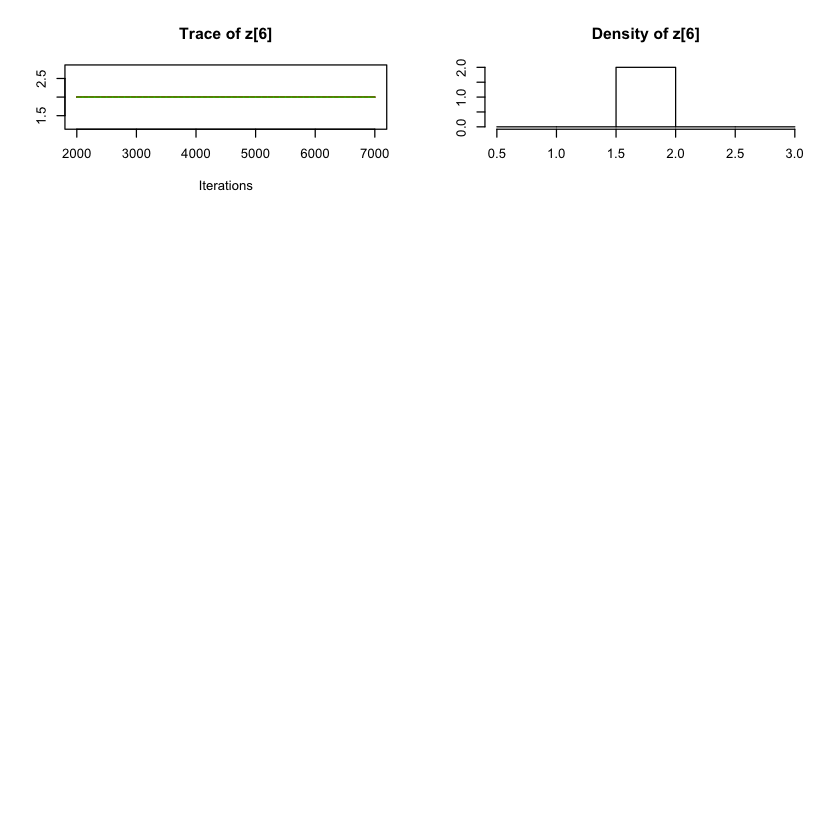

In [92]:
## convergence diagnostics
plot(mod_sim, ask=TRUE)

autocorr.diag(mod_sim)
effectiveSize(mod_sim)

In [93]:
summary(mod_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean      SD  Naive SE Time-series SE
mu[1]    -2.1261 0.16657 0.0013600      0.0026625
mu[2]     1.4874 0.12509 0.0010213      0.0016932
omega[1]  0.3873 0.04036 0.0003295      0.0004906
omega[2]  0.6127 0.04036 0.0003295      0.0004906
sig       1.1372 0.07483 0.0006110      0.0009613
z[1]      1.0096 0.09751 0.0007962      0.0007962
z[31]     1.5782 0.49386 0.0040324      0.0043834
z[49]     1.8001 0.39996 0.0032657      0.0033554
z[6]      2.0000 0.00000 0.0000000      0.0000000

2. Quantiles for each variable:

            2.5%     25%     50%     75%   97.5%
mu[1]    -2.4488 -2.2390 -2.1261 -2.0163 -1.7984
mu[2]     1.2374  1.4052  1.4892  1.5712  1.7278
omega[1]  0.3104  0.3593  0.3865  0.4144  0.4674
omega[2]  0.5326  0.5856  0.6135  0.6407  0.6896
sig       1.0071  1.0847

- Mu [1]의 사후 평균은 -2이며,이 정규 분포에 대해 대략적으로 보입니다. 
- 그리고 mu [2]는 1.5 정도의 사후 평균을 가지고 있습니다. 그래서 우리는 두 집단을 확인한 것처럼 보입니다.
- 또한 두 정규 분포가 표준 편차가 약 1 인 것처럼 보입니다. 아마 사실 일 것입니다.
- 그룹 1에 속할 확률은 약 39 %이며 그룹 2에 속할 확률은 약 61 %입니다. 약 39 %의 확률로 이곳에있을 가능성이 약 61 %입니다. 그것도 맞아 보인다.
- 이러한 z 변수의 후방 수단을 살펴보기보다는 대신 그래픽으로 그 변수를 살펴 보겠습니다. 나는이 네 가지 다른 zs에 대한 coda 패키지 densplot에서 음모를 만들었습니다. 

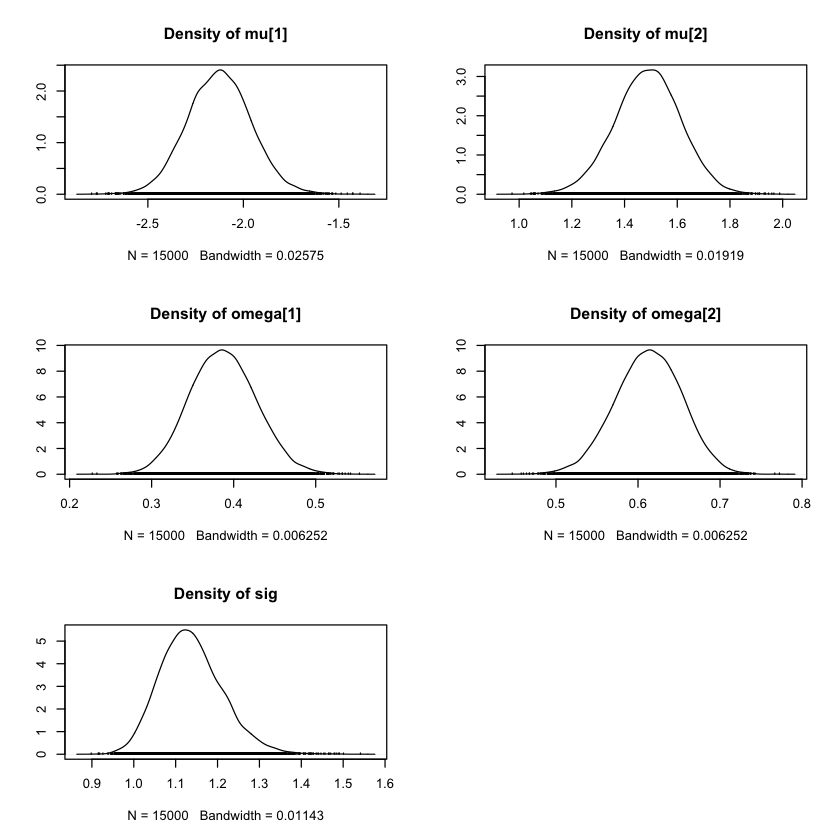

In [94]:
## for the population parameters and the mixing weights
par(mfrow=c(3,2))
densplot(mod_csim[,c("mu[1]", "mu[2]", "omega[1]", "omega[2]", "sig")])

## for the z's
par(mfrow=c(2,2))

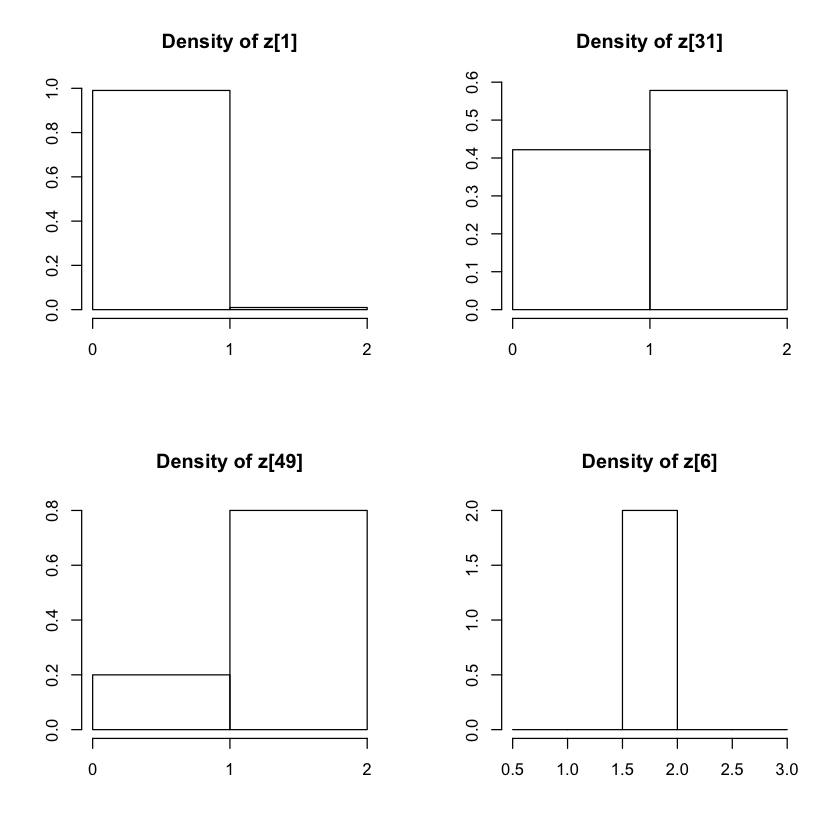

In [98]:
par(mfrow=c(2,2))
densplot(mod_csim[,c("z[1]", "z[31]", "z[49]", "z[6]")])

In [97]:
table(mod_csim[,"z[1]"]) / nrow(mod_csim) ## posterior probabilities for z[1], the membership of y[1]


     1      2 
0.9904 0.0096 

In [99]:
table(mod_csim[,"z[31]"]) / nrow(mod_csim) ## posterior probabilities for z[31], the membership of y[31]


     1      2 
0.4218 0.5782 

In [100]:
table(mod_csim[,"z[49]"]) / nrow(mod_csim) ## posterior probabilities for z[49], the membership of y[49]


        1         2 
0.1999333 0.8000667 

In [101]:
table(mod_csim[,"z[6]"]) / nrow(mod_csim) ## posterior probabilities for z[6], the membership of y[6]


2 
1 

In [102]:
y[c(1, 31, 49, 6)]

[1] -2.2661749 -0.3702666  0.0365564  3.7548080

- 우리가 모니터링 한 z 변수와 관련된 y 값을 살펴보면, y1은 모집단 1의 영토에 명확히 나타나고 y31은 모호하며 y49는 모호하지만 인구 2의 영토에 더 가깝고 y6는 모집단 2의 영토에 분명히 있음을 알 수 있습니다 . z 변수의 사후 분포는 우리의 평가를 반영한다.